In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **FROZEN BACKBONE (GDF / PanDERM/ DINOV2) + shared LR head**

 - Safe PCA, class_weight=balanced
 - TTA = average features per image before LR
 - Binary threshold tuning on validation
 - Unified metrics + Repeat-N wrapper

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ================================================================
# Frozen backbones (GDF / PanDerm / DINOv2) + shared LR head
# - Safe PCA, class_weight=balanced
# - TTA = average features per image before LR
# - Binary threshold tuning on validation
# - Unified metrics + Repeat-N wrapper
# ================================================================

# --- Core imports
import os, io, math, gc, time, random, hashlib, warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from PIL import Image

# Torch / timm (for PanDerm/DINOv2 backbones)
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
import timm
from timm.data import resolve_data_config

# TF (for GDF backbone embeddings)
import tensorflow as tf
from huggingface_hub import from_pretrained_keras

# Sklearn
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    f1_score, accuracy_score, matthews_corrcoef, cohen_kappa_score,
    top_k_accuracy_score, roc_auc_score, classification_report, confusion_matrix
)
from sklearn.dummy import DummyClassifier

# Repro
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED); np.random.seed(GLOBAL_SEED); torch.manual_seed(GLOBAL_SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(GLOBAL_SEED)

In [ ]:
# ---------- GDF embedding cache ----------
CACHE_DIR = "/content/drive/MyDrive/Skin_project/derm_emb_cache"  # your existing cache
os.makedirs(CACHE_DIR, exist_ok=True)

def _sha1(s: str) -> str:
    import hashlib
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

def _emb_cache_path(img_path: str, variant: str = "single") -> str:
    # variant = "single" for one-view; "tta10" (or similar) for TTA-averaged cache
    base = _sha1(f"{img_path}::{variant}")
    return os.path.join(CACHE_DIR, base + ".npy")

def _load_embed_if_cached(img_path: str, variant: str = "single"):
    fp = _emb_cache_path(img_path, variant)
    if os.path.exists(fp):
        try:
            arr = np.load(fp, allow_pickle=False)
            if arr.ndim == 1:  # (6144,)
                return arr.astype(np.float32, copy=False)
        except Exception:
            pass
    return None

def _save_embed_to_cache(img_path: str, emb: np.ndarray, variant: str = "single"):
    fp = _emb_cache_path(img_path, variant)
    try:
        np.save(fp, emb.astype(np.float32), allow_pickle=False)
    except Exception:
        pass


In [ ]:
# ================================================================
# Paths / Features
# ================================================================
CSV_TRAIN_POOL = "/content/drive/MyDrive/Skin_project/train_original.csv"
CSV_SYN_WIDE   = "/content/drive/MyDrive/Skin_project/synthetic_as_wide.csv"  # set True/False when running
CSV_TEST_FIXED = "/content/drive/MyDrive/Skin_project/test_original.csv"

feature2imgcol = {
    "moisture": "moisture_img",
    "oiliness": "oiliness_img",
    "elasticity": "elasticity_img",
    "texture": "texture_img",
    "hyperpigmentation": "hyperpigmentation_img",
}

DEFAULT_LABELS = [-1, 0, 1]
BINARY_MAP = {
    "oiliness": { -1: 0, 0: 1, 1: 1 },  # dry vs non-dry
    "moisture": { -1: 0, 0: 1, 1: 1 },
}
FEATURE_LABELS = {
    "oiliness":  [0, 1],
    "moisture":  [0, 1],
    "texture":   [-1, 0, 1],
    "elasticity":[-1, 0, 1],
    "hyperpigmentation":[-1, 0, 1],
}

VAL_FRAC_WITHIN_TRAIN = 0.125

In [ ]:
# ================================================================
# Dataframe helpers (shared with fine-tune notebook)
# ================================================================
def load_feature_df_one(csv_path, feature):
    df_all  = pd.read_csv(csv_path)
    img_col = feature2imgcol[feature]
    lbl_col = f"{feature}_score"
    cols = ["patient_id", img_col, lbl_col] + (["region"] if "region" in df_all.columns else [])
    df  = df_all[cols].copy().rename(columns={img_col:"image_path", lbl_col:"label"})
    df = df[df["image_path"].apply(lambda p: isinstance(p, str) and os.path.exists(p))]
    df = df.dropna(subset=["label"])
    df["label"] = df["label"].astype(float).round().astype(int)
    if feature in BINARY_MAP:
        df["label"] = df["label"].map(BINARY_MAP[feature])
        df = df.dropna(subset=["label"]).astype({"label": int})
    allowed = FEATURE_LABELS.get(feature, DEFAULT_LABELS)
    df = df[df["label"].isin(allowed)].reset_index(drop=True)
    return df

def load_feature_df_multi(csv_paths, feature):
    frames = [load_feature_df_one(p, feature) for p in csv_paths]
    df = pd.concat(frames, ignore_index=True).drop_duplicates(subset=["image_path"]).reset_index(drop=True)
    return df

def remove_patient_overlap(df_trainpool, df_test):
    overlap = set(df_trainpool.patient_id.unique()) & set(df_test.patient_id.unique())
    if overlap:
        print(f"⚠️ Removing {len(overlap)} patient overlap(s).")
        df_trainpool = df_trainpool[~df_trainpool.patient_id.isin(overlap)].reset_index(drop=True)
    return df_trainpool

def make_val_from_trainpool(df_trainpool, val_frac=VAL_FRAC_WITHIN_TRAIN, seed=42):
    y = df_trainpool["label"].astype(int).values
    groups = df_trainpool["patient_id"].values
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
    N = len(df_trainpool); best = None
    for tr_idx, va_idx in sgkf.split(df_trainpool, y=y, groups=groups):
        frac = len(va_idx) / N
        cand = (abs(frac - val_frac), (tr_idx, va_idx))
        if best is None or cand[0] < best[0]: best = cand
    tr_idx, va_idx = best[1]
    df_tr = df_trainpool.iloc[tr_idx].reset_index(drop=True)
    df_va = df_trainpool.iloc[va_idx].reset_index(drop=True)

    # safety: ensure all classes appear in val if possible
    want = set(df_trainpool["label"].unique())
    have = set(df_va["label"].unique())
    missing = list(want - have)
    if missing:
        for cls in missing:
            cand = df_tr[df_tr["label"] == cls]
            if len(cand):  # move a couple
                take_idx = cand.sample(min(2, len(cand)), random_state=seed).index
                df_va = pd.concat([df_va, df_tr.loc[take_idx]], ignore_index=True)
                df_tr = df_tr.drop(take_idx).reset_index(drop=True)
    return df_tr, df_va

In [ ]:
# chached version note

#•  existing .npy files are the “single” variant (no TTA). The function above will read them as-is when tta=False.
#• When tta=True, it will compute once, save as tta10 (or tta5), and reuse next runs.


#the frozen GDF path will (a) reuse your existing single-view cache, and (b) build & reuse a separate TTA-averaged cache the first time you run with TTA.

In [ ]:
# ================================================================
# Google Derm Foundation (TF) — embedding + TTA
# ================================================================
# Load once
derm_model = from_pretrained_keras("google/derm-foundation")
derm_infer = derm_model.signatures["serving_default"]

In [ ]:
# ---------------- GDF cache helpers ----------------
CACHE_DIR = "/content/drive/MyDrive/Skin_project/derm_emb_cache"  # <- your cache

In [ ]:
# ---------------- GDF cache helpers ----------------
CACHE_DIR = "/content/drive/MyDrive/Skin_project/derm_emb_cache"  # <- your cache

def _sha1(s: str) -> str:
    import hashlib
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

def _emb_cache_path(img_path: str, cache_dir: str) -> str:
    return os.path.join(cache_dir, _sha1(img_path) + ".npy")

def _save_embed_to_cache(img_path: str, cache_dir: str, arr: np.ndarray):
    os.makedirs(cache_dir, exist_ok=True)
    np.save(_emb_cache_path(img_path, cache_dir), arr.astype(np.float32), allow_pickle=False)

def _load_embed_if_cached(img_path: str, cache_dir: str):
    fp = _emb_cache_path(img_path, cache_dir)
    if os.path.exists(fp):
        try:
            arr = np.load(fp, allow_pickle=False)
            if arr.ndim == 1 and arr.dtype == np.float32:
                return arr
        except Exception:
            pass
    return None

# Lazy init of GDF TF model (only if we must infer)
derm_model = None
derm_infer = None
def _ensure_gdf_loaded():
    global derm_model, derm_infer
    if derm_infer is None:
        from huggingface_hub import from_pretrained_keras
        derm_model = from_pretrained_keras("google/derm-foundation")
        derm_infer = derm_model.signatures["serving_default"]

@tf.function
def _gdf_embed_batch(examples):
    outs = derm_infer(inputs=examples)
    return outs["embedding"]  # [B, 6144]

def _png_bytes_from_pil(pil_img: Image.Image) -> bytes:
    import io
    buf = io.BytesIO()
    pil_img.convert("RGB").save(buf, format="PNG")
    return buf.getvalue()

def _tf_example_from_png_bytes(image_bytes: bytes) -> bytes:
    ex = tf.train.Example(features=tf.train.Features(
        feature={'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes]))}
    ))
    return ex.SerializeToString()

def gdf_embeddings_cached(paths, cache_dir, allow_infer=False, tta=False, batch=96):
    """
    Returns (X, keep_idx). If allow_infer=False, only cached vectors are used.
    If allow_infer=True and any are missing, they are computed and cached.
    If tta=True, we compute/average multiple crops (requires inference).
    """
    embs = []
    missing = []
    for p in paths:
        e = _load_embed_if_cached(p, cache_dir)
        if e is None:
            missing.append(p)
            embs.append(None)
        else:
            embs.append(e)

    if (tta or allow_infer) and len(missing) > 0:
        # TTA or fill missing requires inference
        _ensure_gdf_loaded()
        to_fill = {}
        for p in missing:
            try:
                img = Image.open(p)
            except Exception:
                to_fill[p] = None
                continue
            pils = [_ for _ in [img.convert("RGB")] ] if not tta else _gdf_tta_variants(img, use_hflip=True)
            exs  = [_tf_example_from_png_bytes(_png_bytes_from_pil(pi)) for pi in pils]
            vecs = []
            for i in range(0, len(exs), batch):
                sub = tf.constant(exs[i:i+batch])
                v = _gdf_embed_batch(sub).numpy().astype(np.float32)
                vecs.append(v)
            vecs = np.concatenate(vecs, 0) if vecs else np.zeros((0,6144), np.float32)
            to_fill[p] = vecs.mean(0) if len(vecs) else None

        # write back and cache
        for i, p in enumerate(paths):
            if embs[i] is None and p in to_fill and to_fill[p] is not None:
                embs[i] = to_fill[p]
                _save_embed_to_cache(p, cache_dir, embs[i])

    # collect valid
    keep = [i for i, e in enumerate(embs) if e is not None]
    if len(keep) < len(paths):
        print(f"⚠️ GDF cache: using {len(keep)}/{len(paths)} embeddings "
              f"({'no inference' if not (tta or allow_infer) else 'some inferred'})")
    X = np.stack([embs[i] for i in keep], 0) if keep else np.zeros((0,6144), np.float32)
    return X, keep


In [ ]:
# --- add this helper somewhere above run_frozen_lr_backbone ---
import os, hashlib, numpy as np

def _sha1(s: str) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

def gdf_embeddings_from_cache(paths, cache_dir):
    """Return X (N_hit, 6144) and ok_indices (into original 'paths')."""
    ok_idx, feats = [], []
    for i, p in enumerate(paths):
        fp = os.path.join(cache_dir, _sha1(p) + ".npy")
        if os.path.exists(fp):
            try:
                a = np.load(fp, allow_pickle=False)
                if a.ndim == 1 and a.shape[0] == 6144:
                    feats.append(a.astype(np.float32))
                    ok_idx.append(i)
            except Exception:
                pass
    X = np.stack(feats, axis=0) if feats else np.zeros((0, 6144), np.float32)
    return X, ok_idx


In [ ]:
def _png_bytes_from_pil(pil_img: Image.Image) -> bytes:
    buf = io.BytesIO()
    pil_img.convert("RGB").save(buf, format="PNG")
    return buf.getvalue()

def _tf_example_from_png_bytes(image_bytes: bytes) -> bytes:
    ex = tf.train.Example(features=tf.train.Features(
        feature={'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes]))}
    ))
    return ex.SerializeToString()

@tf.function
def _gdf_embed_batch(examples):
    outs = derm_infer(inputs=examples)
    return outs["embedding"]  # [B, 6144]

def _gdf_tta_variants(pil_img, use_hflip=True):
    """Small TTA for GDF: FiveCrop-style without requiring size, plus optional hflip."""
    # make a square from center, then produce 5 crops (TL,TR,BL,BR,center)
    im = pil_img.convert("RGB")
    w,h = im.size; side = min(w,h); l=(w-side)//2; t=(h-side)//2
    sq = im.crop((l,t,l+side,t+side))
    # define 5 crops by percentages
    s = side
    c = s//2
    crops = [
        sq.crop((0,0,c,c)),               # TL
        sq.crop((s-c,0,s,c)),             # TR
        sq.crop((0,s-c,c,s)),             # BL
        sq.crop((s-c,s-c,s,s)),           # BR
        sq.crop(((s-c)//2,(s-c)//2,(s+c)//2,(s+c)//2)),  # center
    ]
    if use_hflip:
        crops += [TF.hflip(c) for c in crops]
    return crops  # list of PIL


def gdf_embeddings(paths, tta=True, batch=96, use_cache=True, allow_infer=False, hflip=True):
    """
    Return per-image GDF embeddings.
    - If tta=False  → use (or build) 'single' cache (compatible with your existing cache).
    - If tta=True   → average over FiveCrop(+flip) and save under variant key like 'tta10'.
    - use_cache=True: try cache first; allow_infer controls whether we compute missing ones.
    """
    embs = []
    variant = "tta10" if tta and hflip else ("tta5" if tta else "single")

    for p in paths:
        # 1) try cache
        if use_cache:
            e_cached = _load_embed_if_cached(p, variant=variant)
            if e_cached is not None:
                embs.append(e_cached); continue
            if (variant != "single"):  # fallback to single if you had only single cached
                e_single = _load_embed_if_cached(p, variant="single")
                if e_single is not None and not allow_infer:
                    # if we’re not allowed to infer, at least return the single-view
                    embs.append(e_single); continue

        # 2) compute if allowed
        if not allow_infer:
            embs.append(None); continue

        try:
            img = Image.open(p)
        except Exception:
            embs.append(None); continue

        if tta:
            pils = _gdf_tta_variants(img, use_hflip=hflip)  # ~10 views
        else:
            pils = [img.convert("RGB")]

        # encode to tf.Example
        exs = [_tf_example_from_png_bytes(_png_bytes_from_pil(pi)) for pi in pils]

        # batched TF inference (CPU)
        E = []
        for i in range(0, len(exs), batch):
            sub = tf.constant(exs[i:i+batch])
            e = _gdf_embed_batch(sub).numpy().astype(np.float32)  # [b,6144]
            E.append(e)
        E = np.concatenate(E, axis=0) if E else np.zeros((0, 6144), np.float32)
        e_mean = E.mean(0) if len(E) else None

        embs.append(e_mean)
        # save to cache
        if e_mean is not None and use_cache:
            _save_embed_to_cache(p, e_mean, variant=variant)

    ok = [i for i,v in enumerate(embs) if v is not None]
    X  = np.stack([embs[i] for i in ok], axis=0) if ok else np.zeros((0,6144), np.float32)
    return X, ok


# ================================================================
# timm encoders (PanDerm/DINOv2) — embedding + TTA
# ================================================================
def _timm_name(backbone: str):
    if backbone == "panderm_b16": return "vit_base_patch16_224"
    if backbone == "panderm_l16": return "vit_large_patch16_224"
    if backbone == "dinov2_b14":  return "vit_base_patch14_dinov2"
    if backbone == "dinov2_l14":  return "vit_large_patch14_dinov2"
    raise ValueError(f"Unknown backbone: {backbone}")

def _interpolate_pos_embed(model, posemb):
    pe_new = model.pos_embed
    if posemb.shape == pe_new.shape: return posemb
    cls_tok, grid = posemb[:, :1], posemb[:, 1:]
    cls_tok_new, grid_new = pe_new[:, :1], pe_new[:, 1:]
    gs_old = int(grid.shape[1] ** 0.5)
    gs_new = int(grid_new.shape[1] ** 0.5)
    grid = grid.reshape(1, gs_old, gs_old, -1).permute(0,3,1,2)
    grid = torch.nn.functional.interpolate(grid, size=(gs_new, gs_new), mode="bicubic", align_corners=False)
    grid = grid.permute(0,2,3,1).reshape(1, gs_new*gs_new, -1)
    return torch.cat([cls_tok_new, grid], dim=1)

def load_panderm_backbone(encoder, ckpt_path, verbose=True):
    sd_raw = torch.load(ckpt_path, map_location="cpu")
    sd = sd_raw.get("model") or sd_raw.get("state_dict") or sd_raw
    def strip(k):
        for p in ("module.","backbone.","encoder.","model."):
            if k.startswith(p): return k[len(p):]
        return k
    enc_sd = encoder.state_dict()
    mapped = {}
    for k,v in sd.items():
        k2 = strip(k)
        if k2 == "pos_embed" and "pos_embed" in enc_sd:
            try: v = _interpolate_pos_embed(encoder, v)
            except Exception: pass
        if k2 in enc_sd and enc_sd[k2].shape == v.shape:
            mapped[k2] = v
    encoder.load_state_dict(mapped, strict=False)
    if verbose:
        miss = set(enc_sd.keys()) - set(mapped.keys())
        print(f"PanDerm load: matched {len(mapped)}/{len(enc_sd)}; missing {len(miss)}")

def build_timm_encoder(backbone, PANDERM_CKPT=None):
    name = _timm_name(backbone)
    if backbone.startswith("dinov2"):
        enc = timm.create_model(name, pretrained=True, num_classes=0)
    else:
        assert PANDERM_CKPT and os.path.exists(PANDERM_CKPT), "Set PANDERM_CKPT"
        enc = timm.create_model(name, pretrained=False, num_classes=0)
        load_panderm_backbone(enc, PANDERM_CKPT, verbose=True)
    enc.eval().to(DEVICE)
    for p in enc.parameters(): p.requires_grad = False

    cfg = resolve_data_config({}, model=enc)
    mean, std = tuple(cfg.get("mean",(0.485,0.456,0.406))), tuple(cfg.get("std",(0.229,0.224,0.225)))
    size = cfg.get("input_size",(3,224,224))[-1]

    pre  = transforms.Resize(int(size*1.5))
    five = transforms.FiveCrop(size)
    post = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
    eval_tfm = transforms.Compose([transforms.Resize(int(size*1.5)), transforms.CenterCrop(size), post])

    return enc, (pre,five,post), eval_tfm

@torch.no_grad()
def timm_embeddings(paths, encoder, eval_tfm, batch=32, num_workers=2):
    class _DS(Dataset):
        def __init__(self, paths, tfm): self.paths=list(paths); self.tfm=tfm
        def __len__(self): return len(self.paths)
        def __getitem__(self, i):
            x = Image.open(self.paths[i]).convert("RGB"); return self.tfm(x)
    ds = _DS(paths, eval_tfm)
    dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=num_workers, pin_memory=True)
    chunks=[]
    for xb in dl:
        xb = xb.to(DEVICE, non_blocking=True)
        z = encoder(xb)
        if z.dim()>2: z=z.mean((2,3))
        chunks.append(z.detach().cpu().numpy())
    return np.concatenate(chunks,0) if chunks else np.zeros((0, encoder.num_features), np.float32)

@torch.no_grad()
def timm_embeddings_tta(paths, encoder, tta_tuple, hflip=True, micro_batch=8):
    pre, five, post = tta_tuple
    feats=[]
    for p in paths:
        try: img = Image.open(p).convert("RGB")
        except Exception: feats.append(None); continue
        img = pre(img)
        crops = list(five(img))
        if hflip: crops += [TF.hflip(c) for c in crops]
        tens = torch.stack([post(c) for c in crops],0)  # [T,3,H,W]
        zs=[]
        for i in range(0, tens.size(0), micro_batch):
            xb = tens[i:i+micro_batch].to(DEVICE)
            z = encoder(xb)
            if z.dim()>2: z=z.mean((2,3))
            zs.append(z.detach().cpu())
        zm = torch.cat(zs,0).mean(0).numpy()
        feats.append(zm)
    ok = [i for i,v in enumerate(feats) if v is not None]
    X  = np.stack([feats[i] for i in ok],0) if ok else np.zeros((0, encoder.num_features), np.float32)
    return X, ok

In [ ]:
# ================================================================
# LR pipeline + metrics
# ================================================================
def choose_pca_components(n_train, n_feat, keep=256):
    cap = min(n_feat, max(0, n_train-1), keep)
    return cap if cap >= 2 else 0

def make_lr_pipeline(n_comp, C=1.0, whiten=True, seed=42):
    if n_comp and n_comp>=2:
        return make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            PCA(n_components=n_comp, whiten=whiten, random_state=seed),
            LogisticRegression(solver="lbfgs", class_weight="balanced", C=C, max_iter=300, random_state=seed),
        )
    else:
        return make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            LogisticRegression(solver="lbfgs", class_weight="balanced", C=C, max_iter=300, random_state=seed),
        )

def tune_threshold_binary(scores, y_true, grid=np.linspace(0.2,0.8,31)):
    best_t, best_f1 = 0.5, -1.0
    for t in grid:
        pred = (scores >= t).astype(int)
        f1 = f1_score(y_true, pred, average="macro", zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return float(best_t)

def _metrics_binary(y_true, y_pred, scores):
    return dict(
        macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0),
        weighted_f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0),
        acc = accuracy_score(y_true, y_pred),
        mcc = matthews_corrcoef(y_true, y_pred),
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic"),
        auroc = roc_auc_score(y_true, scores),
    )


def _metrics_multiclass(y_true, y_pred, proba, label_order=None):
    out = dict(
        macro_f1   = f1_score(y_true, y_pred, average="macro", zero_division=0),
        weighted_f1= f1_score(y_true, y_pred, average="weighted", zero_division=0),
        acc        = accuracy_score(y_true, y_pred),
        mcc        = matthews_corrcoef(y_true, y_pred),
        qwk        = cohen_kappa_score(y_true, y_pred, weights="quadratic"),
        auroc_micro = roc_auc_score(y_true, proba, multi_class="ovr", average="micro",labels=label_order),
        auroc_macro = roc_auc_score(y_true, proba, multi_class="ovr", average="macro",labels=label_order),
    )
    # OPTIONAL (comment out if you don’t want them)
    # out["top2"]        = top_k_accuracy_score(y_true, proba, k=2, labels=label_order)
    # out["auroc_micro"] = roc_auc_score(y_true, proba, multi_class="ovr", average="micro", labels=label_order)
    # out["auroc_macro"] = roc_auc_score(y_true, proba, multi_class="ovr", average="macro", labels=label_order)
    return out


# ================================================================
# Main runner (frozen + LR) for one backbone/feature
# ================================================================

def run_frozen_lr_backbone(
    backbone,               # "gdf" | "panderm_b16" | "panderm_l16" | "dinov2_b14" | "dinov2_l14"
    feature,
    use_synthetic=False,
    PANDERM_CKPT=None,
    C_grid=(1.0,),          # try (0.5, 1.0, 2.0)
    pca_keep=256,
    do_tta=True,
    seed=42,
    verbose_report=True,
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False, # infer & cache any missing
):
    # -- split data
    pools = [CSV_TRAIN_POOL] + ([CSV_SYN_WIDE] if use_synthetic else [])
    df_pool = load_feature_df_multi(pools, feature)
    df_test = load_feature_df_one(CSV_TEST_FIXED, feature)
    df_pool = remove_patient_overlap(df_pool, df_test)
    df_tr, df_va = make_val_from_trainpool(df_pool, val_frac=VAL_FRAC_WITHIN_TRAIN, seed=seed)

    classes = np.array(sorted(FEATURE_LABELS.get(feature, DEFAULT_LABELS)))
    lab2idx = {int(l): i for i,l in enumerate(classes)}
    nC = len(classes); is_binary = (nC==2)

    # -- embeddings
    if backbone == "gdf":
        #X_tr,_ = gdf_embeddings(df_tr.image_path.values, tta=do_tta)
        #X_va,_ = gdf_embeddings(df_va.image_path.values, tta=do_tta)
        #X_te,_ = gdf_embeddings(df_test.image_path.values, tta=do_tta)

        # cache-first path
        #X_tr, keep_tr = gdf_embeddings_cached(df_tr.image_path.values, gdf_cache_dir,
                                              #allow_infer=gdf_allow_infer, tta=do_tta)
        #X_va, keep_va = gdf_embeddings_cached(df_va.image_path.values, gdf_cache_dir,
                                              #allow_infer=gdf_allow_infer, tta=do_tta)
        #X_te, keep_te = gdf_embeddings_cached(df_test.image_path.values, gdf_cache_dir,
                                             # allow_infer=gdf_allow_infer, tta=do_tta)

        # align labels to kept indices
        #y_tr = df_tr.label.values.astype(int)[keep_tr]
        #y_va = df_va.label.values.astype(int)[keep_va]
        #y_te = df_test.label.values.astype(int)[keep_te]


        # cache-only, no TF calls
        X_tr, ok_tr = gdf_embeddings_from_cache(df_tr.image_path.values, gdf_cache_dir)
        X_va, ok_va = gdf_embeddings_from_cache(df_va.image_path.values, gdf_cache_dir)
        X_te, ok_te = gdf_embeddings_from_cache(df_test.image_path.values, gdf_cache_dir)

        # align labels to hits
        y_tr = df_tr.label.values.astype(int)[ok_tr]
        y_va = df_va.label.values.astype(int)[ok_va]
        y_te = df_test.label.values.astype(int)[ok_te]

        print(f"[GDF cache] hits  train {len(ok_tr)}/{len(df_tr)} | "
              f"val {len(ok_va)}/{len(df_va)} | test {len(ok_te)}/{len(df_test)}")

        # Safety check: abort early if we have almost no data
        if len(X_tr) < 5 or len(np.unique(y_tr)) < 2:
            raise RuntimeError("Too few cached embeddings or single-class train fold. "
                              "Check cache paths or enable gdf_allow_infer=True to fill misses.")

    else:
        enc, tta_tuple, eval_tfm = build_timm_encoder(backbone, PANDERM_CKPT=PANDERM_CKPT)
        if do_tta:
            X_tr,_ = timm_embeddings_tta(df_tr.image_path.values,  enc, tta_tuple, hflip=True)
            X_va,_ = timm_embeddings_tta(df_va.image_path.values,  enc, tta_tuple, hflip=True)
            X_te,_ = timm_embeddings_tta(df_test.image_path.values, enc, tta_tuple, hflip=True)
        else:
            X_tr   = timm_embeddings(df_tr.image_path.values,  enc, eval_tfm)
            X_va   = timm_embeddings(df_va.image_path.values,  enc, eval_tfm)
            X_te   = timm_embeddings(df_test.image_path.values, enc, eval_tfm)

    y_tr = df_tr.label.values.astype(int)
    y_va = df_va.label.values.astype(int)
    y_te = df_test.label.values.astype(int)

    # -- train LR (grid on C; PCA safe cap)
    best = None
    for C in C_grid:
        n_comp = choose_pca_components(len(X_tr), X_tr.shape[1], keep=pca_keep)
        clf = make_lr_pipeline(n_comp, C=C, whiten=True, seed=seed)
        clf.fit(X_tr, y_tr)
        va_pred = clf.predict(X_va)
        va_f1   = f1_score(y_va, va_pred, average="macro", zero_division=0)
        if (best is None) or (va_f1 > best["va_f1"]):
            best = {"C": C, "va_f1": va_f1, "clf": clf, "n_comp": n_comp}
    clf = best["clf"]

    report = {"backbone": backbone, "feature": feature, "use_synth": bool(use_synthetic),
              "C": best["C"], "pca_comp": best["n_comp"], "val_macroF1": float(best["va_f1"])}

    # -- evaluate (threshold-tuned for binary)
    if is_binary:
        va_scores = clf.predict_proba(X_va)[:,1]
        thr = tune_threshold_binary(va_scores, y_va)
        te_scores = clf.predict_proba(X_te)[:,1]
        y_pred = (te_scores >= thr).astype(int)
        metrics = _metrics_binary(y_te, y_pred, te_scores)
        report.update(metrics)
        report["threshold"] = float(thr)
        if verbose_report:
            print(f"\n[{backbone} · {feature} · frozen+LR{' + TTA' if do_tta else ''}]")
            print(f"C={best['C']}  PCA={best['n_comp']}  thr={thr:.3f}  val_macroF1={best['va_f1']:.3f}")
            print(f"macro-F1={metrics['macro_f1']:.3f} | weighted-F1={metrics['weighted_f1']:.3f} | "
                  f"acc={metrics['acc']:.3f} | MCC={metrics['mcc']:.3f} | QWK={metrics['qwk']:.3f} | "
                  f"AUROC={metrics['auroc']:.3f}")
    else:
        # --- MULTICLASS EVAL  ---
        lr_step     = clf.named_steps.get("logisticregression", clf[-1])
        classes_lr  = lr_step.classes_                     # e.g., array([-1, 0, 1])
        P           = clf.predict_proba(X_te)              # columns are ordered as classes_lr
        y_pred      = classes_lr[P.argmax(1)]              # map indices -> label values

        metrics = _metrics_multiclass(y_te, y_pred, P, label_order=classes_lr)
        report.update(metrics)

        if verbose_report:
            present = np.unique(y_te)
            print(f"\n[{backbone} · {feature} · frozen+LR{' + TTA' if do_tta else ''}]")
            print(f"C={best['C']}  PCA={best['n_comp']}  val_macroF1={best['va_f1']:.3f}")
            print(f"macro-F1={metrics['macro_f1']:.3f} | weighted-F1={metrics['weighted_f1']:.3f} | "
                  f"acc={metrics['acc']:.3f} | MCC={metrics['mcc']:.3f} | QWK={metrics['qwk']:.3f}")
            print(classification_report(y_te, y_pred, labels=present, digits=3, zero_division=0))
            print("Confusion (rows=true, cols=pred):\n", confusion_matrix(y_te, y_pred, labels=present))

    # free a bit
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()
    return report

# ================================================================
# Dummy baselines (train labels -> test predictions)
# ================================================================
def dummy_baselines_from_labels(y_train, y_test):
    X_tr = np.zeros((len(y_train),1)); X_te = np.zeros((len(y_test),1))
    out = {}
    for strat in ["most_frequent", "uniform"]:
        d = DummyClassifier(strategy=strat, random_state=GLOBAL_SEED).fit(X_tr, y_train)
        yp = d.predict(X_te)
        out[strat] = dict(
            macro_f1 = f1_score(y_test, yp, average="macro", zero_division=0),
            bal_acc  = (confusion_matrix(y_test, yp, labels=np.unique(y_test)).astype(float)
                        / confusion_matrix(y_test, yp, labels=np.unique(y_test)).sum(1, keepdims=True)
                       ).diagonal().mean()
        )
    return out

# small helper to run baselines on current splits
def run_dummy_for_split(df_tr, df_va, df_te):
    y_tr = df_tr.label.values.astype(int)
    y_te = df_te.label.values.astype(int)
    return dummy_baselines_from_labels(y_tr, y_te)


In [ ]:

# ================================================================
# Repeat-N wrapper (seed sweep) with mean±std
# ================================================================

def repeat_avg_frozen(backbone, feature, n_runs=3, base_seed=2025,
                      use_synthetic=True, PANDERM_CKPT=None, C_grid=(1.0,), do_tta=True, #GDF:
                      gdf_cache_dir=CACHE_DIR, gdf_allow_infer=False):
    rows=[]
    for i in range(n_runs):
        s = base_seed + i
        random.seed(s); np.random.seed(s); torch.manual_seed(s)
        if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
        rep = run_frozen_lr_backbone(
            backbone=backbone, feature=feature, use_synthetic=use_synthetic,
            PANDERM_CKPT=PANDERM_CKPT, C_grid=C_grid, do_tta=do_tta, seed=s, verbose_report=False,
            gdf_cache_dir=gdf_cache_dir, gdf_allow_infer=gdf_allow_infer  # <-- GDF
        )
        rows.append(rep)
    df = pd.DataFrame(rows)
    means = df.mean(numeric_only=True)
    stds  = df.std(numeric_only=True)
    summary = {k: float(means[k]) for k in means.index}
    summary.update({f"{k}_std": float(stds[k]) for k in means.index})
    summary.update(dict(backbone=backbone, feature=feature, n_runs=n_runs, use_synth=bool(use_synthetic)))
    print(f"\n[{backbone} · {feature} · frozen+LR{' + TTA' if do_tta else ''} | {n_runs} runs]"
          f" macro-F1={summary.get('macro_f1', np.nan):.3f}±{summary.get('macro_f1_std', np.nan):.3f}"
          f" | acc={summary.get('acc', np.nan):.3f}±{summary.get('acc_std', np.nan):.3f}"
          f" | weighted-F1={summary.get('weighted_f1', np.nan):.3f}±{summary.get('weighted_f1_std', np.nan):.3f}")
    return df, summary

In [ ]:
# ================================================================
# How to run (examples)
# ================================================================
# 1) Real-only vs Real+Synth comparisons
#    (a) GDF (frozen)
# rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
#     backbone="gdf", feature="hyperpigmentation",
#     n_runs=3, base_seed=2025,
#     use_synthetic=False,   # then flip to True to compare
#     C_grid=(0.5,1.0,2.0), do_tta=True
# )

# 2) PanDerm (frozen) — supply checkpoint
# PANDERM_CKPT = "/content/panderm_weights/panderm_bb_data6_checkpoint-499.pth"
# rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
#     backbone="panderm_b16", feature="texture",
#     n_runs=3, base_seed=2025,
#     use_synthetic=True,
#     PANDERM_CKPT=PANDERM_CKPT,
#     C_grid=(0.5,1.0,2.0), do_tta=True
# )

# 3) DINOv2 (frozen)
# rep_dino_el, sum_dino_el = repeat_avg_frozen(
#     backbone="dinov2_b14", feature="elasticity",
#     n_runs=3, base_seed=2025,
#     use_synthetic=True,
#     C_grid=(0.5,1.0,2.0), do_tta=True
# )

# 4) Quick per-run detailed report (not averaged)
# _ = run_frozen_lr_backbone("gdf", "oiliness", use_synthetic=False, C_grid=(1.0,1.5,2.0), do_tta=True)

# ================================================================
# NOTE
# - This file standardizes *frozen* comparisons. Keep your PanDerm/DINOv2 **fine-tune**
#   notebook (StrongHead + Cosine + TTA) separate, using the same metrics printing.
# - For fairness, you can also add *frozen* LR runs of PanDerm/DINOv2 alongside GDF.
# ================================================================


# **GDF**

## 5. Hyperpigmentation

## Real only

In [ ]:
# GDF - CACHED, NO INFERENCE
rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
    backbone="gdf",
    feature="hyperpigmentation",
    n_runs=3, base_seed=2025,
    use_synthetic=False,
    C_grid=(0.5,1.0,2.0),
    do_tta=False,                 # keep False to stay cache-only
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False
)


[GDF cache] hits  train 48/48 | val 13/13 | test 16/16
[GDF cache] hits  train 48/48 | val 13/13 | test 16/16
[GDF cache] hits  train 48/48 | val 13/13 | test 16/16

[gdf · hyperpigmentation · frozen+LR | 3 runs] macro-F1=0.466±0.041 | acc=0.646±0.072 | weighted-F1=0.609±0.056


### with Synthetic Data

In [ ]:
# GDF - CACHED, NO INFERENCE
rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
    backbone="gdf",
    feature="hyperpigmentation",
    n_runs=3, base_seed=2025,
    use_synthetic=True,
    C_grid=(0.5,1.0,2.0),
    do_tta=False,
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False         # <-- crucial: do not touch TF model
)


[GDF cache] hits  train 94/94 | val 17/17 | test 16/16
[GDF cache] hits  train 93/93 | val 18/18 | test 16/16
[GDF cache] hits  train 90/90 | val 21/21 | test 16/16

[gdf · hyperpigmentation · frozen+LR | 3 runs] macro-F1=0.588±0.092 | acc=0.750±0.000 | weighted-F1=0.715±0.030


## 1. Moisture

### Real only

In [ ]:
# GDF - CACHED, NO INFERENCE
rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
    backbone="gdf",
    feature="moisture",
    n_runs=3, base_seed=2025,
    use_synthetic=False,
    C_grid=(0.5,1.0,2.0),
    do_tta=False,                 # keep False to stay cache-only
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False
)

[GDF cache] hits  train 50/50 | val 11/11 | test 16/16
[GDF cache] hits  train 49/49 | val 12/12 | test 16/16
[GDF cache] hits  train 48/48 | val 13/13 | test 16/16

[gdf · moisture · frozen+LR | 3 runs] macro-F1=0.532±0.086 | acc=0.542±0.095 | weighted-F1=0.541±0.091


### with Synth data

In [ ]:
# GDF - CACHED, NO INFERENCE
rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
    backbone="gdf",
    feature="moisture",
    n_runs=3, base_seed=2025,
    use_synthetic=True,
    C_grid=(0.5,1.0,2.0),
    do_tta=False,                 # keep False to stay cache-only
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False
)

[GDF cache] hits  train 93/93 | val 18/18 | test 16/16
[GDF cache] hits  train 92/92 | val 19/19 | test 16/16
[GDF cache] hits  train 93/93 | val 18/18 | test 16/16

[gdf · moisture · frozen+LR | 3 runs] macro-F1=0.542±0.068 | acc=0.562±0.062 | weighted-F1=0.564±0.062


## 2. Oiliness

### Real only

In [ ]:
# GDF - CACHED, NO INFERENCE
rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
    backbone="gdf",
    feature="oiliness",
    n_runs=3, base_seed=2025,
    use_synthetic=False,
    C_grid=(0.5,1.0,2.0),
    do_tta=False,                 # keep False to stay cache-only
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False
)

[GDF cache] hits  train 50/50 | val 11/11 | test 16/16
[GDF cache] hits  train 50/50 | val 11/11 | test 16/16
[GDF cache] hits  train 50/50 | val 11/11 | test 16/16

[gdf · oiliness · frozen+LR | 3 runs] macro-F1=0.429±0.000 | acc=0.750±0.000 | weighted-F1=0.750±0.000


### With Synth data

In [ ]:
# GDF - CACHED, NO INFERENCE
rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
    backbone="gdf",
    feature="oiliness",
    n_runs=3, base_seed=2025,
    use_synthetic=True,
    C_grid=(0.5,1.0,2.0),
    do_tta=False,                 # keep False to stay cache-only
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False
)

[GDF cache] hits  train 88/88 | val 23/23 | test 16/16
[GDF cache] hits  train 91/91 | val 20/20 | test 16/16
[GDF cache] hits  train 93/93 | val 18/18 | test 16/16

[gdf · oiliness · frozen+LR | 3 runs] macro-F1=0.454±0.011 | acc=0.833±0.036 | weighted-F1=0.795±0.019


## 3. Elasticity

### Real only

In [ ]:
# GDF - CACHED, NO INFERENCE
rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
    backbone="gdf",
    feature="elasticity",
    n_runs=3, base_seed=2025,
    use_synthetic=False,
    C_grid=(0.5,1.0,2.0),
    do_tta=False,                 # keep False to stay cache-only
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False
)

[GDF cache] hits  train 45/45 | val 16/16 | test 16/16
[GDF cache] hits  train 48/48 | val 13/13 | test 16/16
[GDF cache] hits  train 50/50 | val 11/11 | test 16/16

[gdf · elasticity · frozen+LR | 3 runs] macro-F1=0.271±0.015 | acc=0.396±0.036 | weighted-F1=0.343±0.023


### With Synth data

In [ ]:
# GDF - CACHED, NO INFERENCE
rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
    backbone="gdf",
    feature="elasticity",
    n_runs=3, base_seed=2025,
    use_synthetic=True,
    C_grid=(0.5,1.0,2.0),
    do_tta=False,                 # keep False to stay cache-only
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False
)

[GDF cache] hits  train 93/93 | val 18/18 | test 16/16
[GDF cache] hits  train 88/88 | val 23/23 | test 16/16
[GDF cache] hits  train 91/91 | val 20/20 | test 16/16

[gdf · elasticity · frozen+LR | 3 runs] macro-F1=0.279±0.104 | acc=0.396±0.036 | weighted-F1=0.267±0.060


## 4. Texture



### Real only

In [ ]:
# GDF - CACHED, NO INFERENCE
rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
    backbone="gdf",
    feature="texture",
    n_runs=3, base_seed=2025,
    use_synthetic=False,
    C_grid=(0.5,1.0,2.0),
    do_tta=False,                 # keep False to stay cache-only
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False
)

[GDF cache] hits  train 48/48 | val 13/13 | test 16/16
[GDF cache] hits  train 50/50 | val 11/11 | test 16/16
[GDF cache] hits  train 47/47 | val 14/14 | test 16/16

[gdf · texture · frozen+LR | 3 runs] macro-F1=0.366±0.059 | acc=0.583±0.036 | weighted-F1=0.540±0.042


### With Synth data

In [ ]:
# GDF - CACHED, NO INFERENCE
rep_gdf_hp, sum_gdf_hp = repeat_avg_frozen(
    backbone="gdf",
    feature="texture",
    n_runs=3, base_seed=2024,
    use_synthetic=True,
    C_grid=(0.5,1.0,2.0),
    do_tta=False,                 # keep False to stay cache-only
    gdf_cache_dir=CACHE_DIR,
    gdf_allow_infer=False
)

[GDF cache] hits  train 92/92 | val 19/19 | test 16/16
[GDF cache] hits  train 93/93 | val 18/18 | test 16/16
[GDF cache] hits  train 89/89 | val 22/22 | test 16/16

[gdf · texture · frozen+LR | 3 runs] macro-F1=0.367±0.112 | acc=0.625±0.062 | weighted-F1=0.554±0.094


# **PANDERM**  (Large)

In [ ]:
%%bash
set -e
pip -q install gdown
mkdir -p /content/panderm_weights

# ViT-Large (paper model)
gdown --fuzzy "https://drive.google.com/file/d/1SwEzaOlFV_gBKf2UzeowMC8z9UH7AQbE/view?usp=sharing" \
  -O /content/panderm_weights/panderm_ll_data6_checkpoint-499.pth

# ViT-Base (smaller)
gdown --fuzzy "https://drive.google.com/file/d/17J4MjsZu3gdBP6xAQi_NMDVvH65a00HB/view?usp=sharing" \
  -O /content/panderm_weights/panderm_bb_data6_checkpoint-499.pth

ls -lh /content/panderm_weights


total 1.7G
-rw-r--r-- 1 root root 328M Apr 29 01:40 panderm_bb_data6_checkpoint-499.pth
-rw-r--r-- 1 root root 1.4G Apr 29 01:41 panderm_ll_data6_checkpoint-499.pth


Downloading...
From (original): https://drive.google.com/uc?id=1SwEzaOlFV_gBKf2UzeowMC8z9UH7AQbE
From (redirected): https://drive.google.com/uc?id=1SwEzaOlFV_gBKf2UzeowMC8z9UH7AQbE&confirm=t&uuid=3343f877-3538-49dd-8532-d1b4f6236581
To: /content/panderm_weights/panderm_ll_data6_checkpoint-499.pth
100%|██████████| 1.42G/1.42G [00:20<00:00, 69.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=17J4MjsZu3gdBP6xAQi_NMDVvH65a00HB
From (redirected): https://drive.google.com/uc?id=17J4MjsZu3gdBP6xAQi_NMDVvH65a00HB&confirm=t&uuid=b8c78451-6e40-4d19-a015-69aaa5afd4f8
To: /content/panderm_weights/panderm_bb_data6_checkpoint-499.pth
100%|██████████| 343M/343M [00:06<00:00, 55.8MB/s]


In [ ]:
PANDERM_CKPT = "/content/panderm_weights/panderm_ll_data6_checkpoint-499.pth"

## 1. Moisture

### Real only

In [ ]:
# 2) PanDerm (frozen) — supply checkpoint

rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
     backbone="panderm_l16", feature="moisture",
     n_runs=3, base_seed=2025,
     use_synthetic=False,
     PANDERM_CKPT=PANDERM_CKPT,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24

[panderm_l16 · moisture · frozen+LR + TTA | 3 runs] macro-F1=0.621±0.058 | acc=0.625±0.062 | weighted-F1=0.628±0.062


### With Synth Data

In [ ]:
# 2) PanDerm (frozen) — supply checkpoint

rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
     backbone="panderm_l16", feature="moisture",
     n_runs=3, base_seed=2025,
     use_synthetic=True,
     PANDERM_CKPT=PANDERM_CKPT,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24

[panderm_l16 · moisture · frozen+LR + TTA | 3 runs] macro-F1=0.574±0.124 | acc=0.604±0.130 | weighted-F1=0.601±0.122


## 2. Oiliness

### Real only

In [ ]:
# 2) PanDerm (frozen) — supply checkpoint

rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
     backbone="panderm_l16", feature="oiliness",
     n_runs=3, base_seed=2025,
     use_synthetic=False,
     PANDERM_CKPT=PANDERM_CKPT,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24

[panderm_l16 · oiliness · frozen+LR + TTA | 3 runs] macro-F1=0.428±0.020 | acc=0.750±0.062 | weighted-F1=0.749±0.036


### With synth

In [ ]:
# 2) PanDerm (frozen) — supply checkpoint

rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
     backbone="panderm_l16", feature="oiliness",
     n_runs=3, base_seed=2025,
     use_synthetic=True,
     PANDERM_CKPT=PANDERM_CKPT,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24

[panderm_l16 · oiliness · frozen+LR + TTA | 3 runs] macro-F1=0.442±0.011 | acc=0.792±0.036 | weighted-F1=0.773±0.020


## 3. Elasticity

### Real only

In [ ]:
# 2) PanDerm (frozen) — supply checkpoint

rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
     backbone="panderm_l16", feature="elasticity",
     n_runs=3, base_seed=2025,
     use_synthetic=False,
     PANDERM_CKPT=PANDERM_CKPT,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24

[panderm_l16 · elasticity · frozen+LR + TTA | 3 runs] macro-F1=0.353±0.093 | acc=0.500±0.125 | weighted-F1=0.460±0.127


### With Synth data

In [ ]:
# 2) PanDerm (frozen) — supply checkpoint

rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
     backbone="panderm_l16", feature="elasticity",
     n_runs=3, base_seed=2025,
     use_synthetic=True,
     PANDERM_CKPT=PANDERM_CKPT,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24

[panderm_l16 · elasticity · frozen+LR + TTA | 3 runs] macro-F1=0.395±0.068 | acc=0.479±0.072 | weighted-F1=0.466±0.071


## 4. Texture

### Real only

In [ ]:
# 2) PanDerm (frozen) — supply checkpoint

rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
     backbone="panderm_l16", feature="texture",
     n_runs=3, base_seed=2025,
     use_synthetic=False,
     PANDERM_CKPT=PANDERM_CKPT,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24

[panderm_l16 · texture · frozen+LR + TTA | 3 runs] macro-F1=0.283±0.128 | acc=0.521±0.130 | weighted-F1=0.448±0.105


### With Synth data

In [ ]:
# 2) PanDerm (frozen) — supply checkpoint

rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
     backbone="panderm_l16", feature="texture",
     n_runs=3, base_seed=2025,
     use_synthetic=True,
     PANDERM_CKPT=PANDERM_CKPT,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24

[panderm_l16 · texture · frozen+LR + TTA | 3 runs] macro-F1=0.315±0.136 | acc=0.562±0.062 | weighted-F1=0.479±0.064


## 5. Hyperpigmentation

### Real only

In [ ]:
# 2) PanDerm (frozen) — supply checkpoint

rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
     backbone="panderm_l16", feature="hyperpigmentation",
     n_runs=3, base_seed=2025,
     use_synthetic=False,
     PANDERM_CKPT=PANDERM_CKPT,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24

[panderm_l16 · hyperpigmentation · frozen+LR + TTA | 3 runs] macro-F1=0.385±0.050 | acc=0.562±0.062 | weighted-F1=0.515±0.063


### With Synth data

In [ ]:
# 2) PanDerm (frozen) — supply checkpoint

rep_pan_tex, sum_pan_tex = repeat_avg_frozen(
     backbone="panderm_l16", feature="hyperpigmentation",
     n_runs=3, base_seed=2025,
     use_synthetic=True,
     PANDERM_CKPT=PANDERM_CKPT,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24
PanDerm load: matched 270/294; missing 24

[panderm_l16 · hyperpigmentation · frozen+LR + TTA | 3 runs] macro-F1=0.529±0.201 | acc=0.604±0.144 | weighted-F1=0.591±0.166


# **DINOv2**

## 1. Moisture

### Real-only

In [ ]:
# DINOv2 (frozen)
rep_dino_el, sum_dino_el = repeat_avg_frozen(
     backbone="dinov2_b14", feature="moisture",
     n_runs=3, base_seed=2025,
     use_synthetic=False,
     C_grid=(0.5,1.0,2.0), do_tta=True
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


[dinov2_b14 · moisture · frozen+LR + TTA | 3 runs] macro-F1=0.552±0.055 | acc=0.583±0.072 | weighted-F1=0.569±0.081


### With synth

In [ ]:
# DINOv2 (frozen)
rep_dino_el, sum_dino_el = repeat_avg_frozen(
     backbone="dinov2_b14", feature="moisture",
     n_runs=3, base_seed=2025,
     use_synthetic=True,
     C_grid=(0.5,1.0,2.0), do_tta=True
)


[dinov2_b14 · moisture · frozen+LR + TTA | 3 runs] macro-F1=0.564±0.062 | acc=0.583±0.072 | weighted-F1=0.586±0.068


## 2. Oiliness

### Real-only

In [ ]:
# DINOv2 (frozen)
rep_dino_el, sum_dino_el = repeat_avg_frozen(
     backbone="dinov2_b14", feature="oiliness",
     n_runs=3, base_seed=2025,
     use_synthetic=False,
     C_grid=(0.5,1.0,2.0), do_tta=True
)


[dinov2_b14 · oiliness · frozen+LR + TTA | 3 runs] macro-F1=0.434±0.030 | acc=0.771±0.095 | weighted-F1=0.760±0.053


### With synth

In [ ]:
# DINOv2 (frozen)
rep_dino_el, sum_dino_el = repeat_avg_frozen(
     backbone="dinov2_b14", feature="oiliness",
     n_runs=3, base_seed=2025,
     use_synthetic=True,
     C_grid=(0.5,1.0,2.0), do_tta=True
)


[dinov2_b14 · oiliness · frozen+LR + TTA | 3 runs] macro-F1=0.427±0.037 | acc=0.750±0.108 | weighted-F1=0.747±0.064


## 3. Elasticity

### Real-only

In [ ]:
# DINOv2 (frozen)
rep_dino_el, sum_dino_el = repeat_avg_frozen(
     backbone="dinov2_b14", feature="elasticity",
     n_runs=3, base_seed=2025,
     use_synthetic=False,
     C_grid=(0.5,1.0,2.0), do_tta=True
)


[dinov2_b14 · elasticity · frozen+LR + TTA | 3 runs] macro-F1=0.270±0.078 | acc=0.438±0.062 | weighted-F1=0.334±0.114


### With synth

In [ ]:
# DINOv2 (frozen)
rep_dino_el, sum_dino_el = repeat_avg_frozen(
     backbone="dinov2_b14", feature="elasticity",
     n_runs=3, base_seed=2025,
     use_synthetic=True,
     C_grid=(0.5,1.0,2.0), do_tta=True
)


[dinov2_b14 · elasticity · frozen+LR + TTA | 3 runs] macro-F1=0.340±0.025 | acc=0.479±0.036 | weighted-F1=0.446±0.035


## 4. Texture

### Real-only

In [ ]:
# DINOv2 (frozen)
rep_dino_el, sum_dino_el = repeat_avg_frozen(
     backbone="dinov2_b14", feature="texture",
     n_runs=3, base_seed=2025,
     use_synthetic=False,
     C_grid=(0.5,1.0,2.0), do_tta=True
)


[dinov2_b14 · texture · frozen+LR + TTA | 3 runs] macro-F1=0.253±0.075 | acc=0.396±0.072 | weighted-F1=0.400±0.076


### With Synth

In [ ]:
# DINOv2 (frozen)
rep_dino_el, sum_dino_el = repeat_avg_frozen(
     backbone="dinov2_b14", feature="texture",
     n_runs=3, base_seed=2025,
     use_synthetic=True,
     C_grid=(0.5,1.0,2.0), do_tta=True
)


[dinov2_b14 · texture · frozen+LR + TTA | 3 runs] macro-F1=0.290±0.041 | acc=0.458±0.095 | weighted-F1=0.447±0.085


## 5. Hyperpigmentation

### Real-only

In [ ]:
# DINOv2 (frozen)
rep_dino_el, sum_dino_el = repeat_avg_frozen(
     backbone="dinov2_b14", feature="hyperpigmentation",
     n_runs=3, base_seed=2025,
     use_synthetic=False,
     C_grid=(0.5,1.0,2.0), do_tta=True
)


[dinov2_b14 · hyperpigmentation · frozen+LR + TTA | 3 runs] macro-F1=0.545±0.117 | acc=0.667±0.036 | weighted-F1=0.645±0.040


### With synth

In [ ]:
# DINOv2 (frozen)
rep_dino_el, sum_dino_el = repeat_avg_frozen(
     backbone="dinov2_b14", feature="hyperpigmentation",
     n_runs=3, base_seed=2025,
     use_synthetic=True,
     C_grid=(0.5,1.0,2.0), do_tta=True
)


[dinov2_b14 · hyperpigmentation · frozen+LR + TTA | 3 runs] macro-F1=0.544±0.083 | acc=0.750±0.125 | weighted-F1=0.709±0.107


# **FINE TUNING (PANDERM/DINOV2)**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%bash
set -e
pip -q install gdown
mkdir -p /content/panderm_weights

# ViT-Large (paper model)
gdown --fuzzy "https://drive.google.com/file/d/1SwEzaOlFV_gBKf2UzeowMC8z9UH7AQbE/view?usp=sharing" \
  -O /content/panderm_weights/panderm_ll_data6_checkpoint-499.pth

# ViT-Base (smaller)
gdown --fuzzy "https://drive.google.com/file/d/17J4MjsZu3gdBP6xAQi_NMDVvH65a00HB/view?usp=sharing" \
  -O /content/panderm_weights/panderm_bb_data6_checkpoint-499.pth

ls -lh /content/panderm_weights


total 1.7G
-rw-r--r-- 1 root root 328M Apr 29 01:40 panderm_bb_data6_checkpoint-499.pth
-rw-r--r-- 1 root root 1.4G Apr 29 01:41 panderm_ll_data6_checkpoint-499.pth


Downloading...
From (original): https://drive.google.com/uc?id=1SwEzaOlFV_gBKf2UzeowMC8z9UH7AQbE
From (redirected): https://drive.google.com/uc?id=1SwEzaOlFV_gBKf2UzeowMC8z9UH7AQbE&confirm=t&uuid=3c2c63ad-a107-4655-aaaf-1be7ff5dd5bb
To: /content/panderm_weights/panderm_ll_data6_checkpoint-499.pth
100%|██████████| 1.42G/1.42G [00:17<00:00, 81.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=17J4MjsZu3gdBP6xAQi_NMDVvH65a00HB
From (redirected): https://drive.google.com/uc?id=17J4MjsZu3gdBP6xAQi_NMDVvH65a00HB&confirm=t&uuid=37a5867c-1c95-4649-b588-a3caf55da682
To: /content/panderm_weights/panderm_bb_data6_checkpoint-499.pth
100%|██████████| 343M/343M [00:05<00:00, 64.4MB/s]


In [3]:
from sklearn.model_selection import StratifiedGroupKFold

In [4]:
# ================================================================
# Backbone toggle (PanDerm / DINOv2)
# ================================================================
import os
import timm
from timm.data import resolve_data_config

# OPTIONS:
#   "panderm_b16", "panderm_l16"   (needs PANDERM_CKPT)
#   "dinov2_b14", "dinov2_l14"     (pretrained=True via timm)
BACKBONE = "dinov2_b14"

# If you use PanDerm set this path:
PANDERM_CKPT = "/content/panderm_weights/panderm_ll_data6_checkpoint-499.pth"

# Global stats used by the Datasets
IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)

def _interpolate_pos_embed(model, posemb):
    pe_new = model.pos_embed
    if posemb.shape == pe_new.shape:
        return posemb
    cls_tok, grid = posemb[:, :1], posemb[:, 1:]
    cls_tok_new, grid_new = pe_new[:, :1], pe_new[:, 1:]
    gs_old = int(grid.shape[1] ** 0.5)
    gs_new = int(grid_new.shape[1] ** 0.5)
    grid = grid.reshape(1, gs_old, gs_old, -1).permute(0,3,1,2)
    grid = torch.nn.functional.interpolate(
        grid, size=(gs_new, gs_new), mode="bicubic", align_corners=False
    )
    grid = grid.permute(0,2,3,1).reshape(1, gs_new*gs_new, -1)
    return torch.cat([cls_tok_new, grid], dim=1)

def load_panderm_backbone(encoder, ckpt_path, verbose=True):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt.get("model") or ckpt.get("state_dict") or ckpt

    def strip(k):
        for p in ("module.", "backbone.", "encoder.", "model."):
            if k.startswith(p): return k[len(p):]
        return k

    enc_sd = encoder.state_dict()
    mapped = {}
    for k, v in sd.items():
        k2 = strip(k)
        if k2 == "pos_embed" and "pos_embed" in enc_sd:
            try:
                v = _interpolate_pos_embed(encoder, v)
            except Exception:
                pass
        if k2 in enc_sd and enc_sd[k2].shape == v.shape:
            mapped[k2] = v

    missing = set(enc_sd.keys()) - set(mapped.keys())
    encoder.load_state_dict(mapped, strict=False)
    if verbose:
        print(f"PanDerm load: matched {len(mapped)}/{len(enc_sd)} params; "
              f"missing {len(missing)}.")

def _make_timm_name(backbone: str):
    if backbone == "panderm_b16": return "vit_base_patch16_224"
    if backbone == "panderm_l16": return "vit_large_patch16_224"
    if backbone == "dinov2_b14":  return "vit_base_patch14_dinov2"
    if backbone == "dinov2_l14":  return "vit_large_patch14_dinov2"
    raise ValueError(f"Unknown BACKBONE: {backbone}")

def create_encoder_from_choice(backbone=BACKBONE):
    # Declare globals BEFORE any use in this function
    global IMNET_MEAN, IMNET_STD, CROP_TO, RESIZE_TO

    name = _make_timm_name(backbone)

    # Create encoder
    if backbone.startswith(("dinov2")):
        enc = timm.create_model(name, pretrained=True, num_classes=0)
    else:
        enc = timm.create_model(name, pretrained=False, num_classes=0)

    # Optional PanDerm checkpoint
    if backbone.startswith("panderm"):
        assert "PANDERM_CKPT" in globals() and os.path.exists(PANDERM_CKPT), \
            "Set PANDERM_CKPT to a valid file when using a PanDerm backbone."
        load_panderm_backbone(enc, PANDERM_CKPT, verbose=True)

    # Update mean/std & input size for your Datasets
    cfg = resolve_data_config({}, model=enc)
    mean = tuple(cfg["mean"]) if "mean" in cfg else IMNET_MEAN
    std  = tuple(cfg["std"])  if "std"  in cfg else IMNET_STD
    input_size = cfg.get("input_size", (3, 224, 224))
    H = input_size[-1] if isinstance(input_size, (list, tuple)) else 224

    IMNET_MEAN, IMNET_STD = mean, std
    # If CROP_TO/RESIZE_TO don't exist yet, this will create them
    CROP_TO  = H
    RESIZE_TO = max(384, H * (384 // 224))  # simple heuristic

    print(f"[Backbone={backbone}] input={input_size}  mean={IMNET_MEAN}  std={IMNET_STD}")
    return enc


In [5]:
# ================================================================
# Setup
# ================================================================
import os, gc, math, time, random
import numpy as np
import pandas as pd
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import timm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED   = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [6]:
from torchvision import transforms
from torchvision.transforms import functional as TF

### Per feature

In [7]:
# ================================================================
# Config
# ================================================================
CSV_TRAIN_POOL = "/content/drive/MyDrive/Skin_project/train_original.csv"
CSV_SYN_WIDE   = "/content/drive/MyDrive/Skin_project/synthetic_as_wide.csv"
CSV_TEST_FIXED = "/content/drive/MyDrive/Skin_project/test_original.csv"

# Single feature
FEATURE = "moisture"

# Map feature -> image-path column
feature2imgcol = {
    "moisture": "moisture_img",
    "oiliness": "oiliness_img",
    "elasticity": "elasticity_img",
    "texture": "texture_img",
    "hyperpigmentation": "hyperpigmentation_img",
}

# Label spaces & binary remaps
DEFAULT_LABELS = [-1, 0, 1]
BINARY_MAP = {
    "oiliness": { -1: 0, 0: 1, 1: 1 },  # dry vs non-dry
    "moisture": { -1: 0, 0: 1, 1: 1 },
}
FEATURE_LABELS = {
    "oiliness":  [0, 1],
    "moisture":  [0, 1],
    "texture":   [-1, 0, 1],
    "elasticity":[-1, 0, 1],
    "hyperpigmentation":[-1, 0, 1],
}


# Image sizes & data params (BiT/ViT style)
RESIZE_TO = 384
CROP_TO   = 224
BATCH     = 8
NUM_WORKERS = 2
VAL_FRAC_WITHIN_TRAIN = 0.125

# TARGETED OVERSAMPLING FOR BINARY
# Targeted oversampling for the minority class (oiliness: label 1)
TARGET_MINORITY_FRAC = 0.45  # aim for ~35% positive in the training batches
AUG_MINOR_PROB = 0.7        # probability to apply targeted photometric aug on minority
AUG_MAJOR_PROB = 0.1        # lower prob on majority to avoid shifting distribution

# Fine-tuning schedule
EPOCHS_WARMUP = 3     # head-only
#EPOCHS_FT     = 15   # unfreeze top blocks (or full) at tiny LR
LR_HEAD       = 3e-4
LR_FT         = 3e-5
WD            = 2e-4
PATIENCE_F1   = 5    # early stop on val macro-F1

# Model size
TIMM_BACKBONE = "vit_large_patch16_224"  # or "vit_base_patch16_224" if RAM is tigh
UNFREEZE_LAST_BLOCKS = 3

In [8]:
# ================================================================
# Data loading
# ================================================================
def load_feature_df_one(csv_path, feature):
    df_all  = pd.read_csv(csv_path)
    img_col = feature2imgcol[feature]
    lbl_col = f"{feature}_score"
    cols = ["patient_id", img_col, lbl_col] + (["region"] if "region" in df_all.columns else [])
    df  = df_all[cols].copy().rename(columns={img_col:"image_path", lbl_col:"label"})

    df = df[df["image_path"].apply(lambda p: isinstance(p, str) and os.path.exists(p))]
    df = df.dropna(subset=["label"])
    df["label"] = df["label"].astype(float).round().astype(int)

    if feature in BINARY_MAP:
        df["label"] = df["label"].map(BINARY_MAP[feature])
        df = df.dropna(subset=["label"]).astype({"label": int})

    allowed = FEATURE_LABELS.get(feature, DEFAULT_LABELS)
    df = df[df["label"].isin(allowed)].reset_index(drop=True)
    return df

def load_feature_df_multi(csv_paths, feature):
    frames = [load_feature_df_one(p, feature) for p in csv_paths]
    df = pd.concat(frames, ignore_index=True)
    return df.drop_duplicates(subset=["image_path"]).reset_index(drop=True)

def remove_patient_overlap(df_trainpool, df_test):
    overlap = set(df_trainpool.patient_id.unique()) & set(df_test.patient_id.unique())
    if overlap:
        print(f" Removing {len(overlap)} patient_id overlap(s).")
        df_trainpool = df_trainpool[~df_trainpool.patient_id.isin(overlap)].reset_index(drop=True)
    return df_trainpool

def make_val_from_trainpool(df_trainpool, val_frac=0.125, seed=42):
    """
    Patient-disjoint AND label-stratified split using StratifiedGroupKFold.
    We create several candidate folds and choose the one closest to val_frac.
    If the chosen fold ends up single-class (tiny data), we move a few samples
    from train to val as a safety net.
    """
    y = df_trainpool["label"].astype(int).values
    groups = df_trainpool["patient_id"].values

    # number of folds (5 works well; gives ~20% val; we'll pick the closest)
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)

    N = len(df_trainpool)
    best = None
    for tr_idx, va_idx in sgkf.split(df_trainpool, y=y, groups=groups):
        frac = len(va_idx) / N
        cand = (abs(frac - val_frac), (tr_idx, va_idx))
        if best is None or cand[0] < best[0]:
            best = cand

    tr_idx, va_idx = best[1]
    df_tr = df_trainpool.iloc[tr_idx].reset_index(drop=True)
    df_va = df_trainpool.iloc[va_idx].reset_index(drop=True)

    # --- Safety net: ensure all classes appear in val
    want_labels = set(df_trainpool["label"].unique())
    have_labels = set(df_va["label"].unique())
    missing = list(want_labels - have_labels)
    if missing:
        rng = np.random.default_rng(seed)
        for cls in missing:
            cand = df_tr[df_tr["label"] == cls]
            if len(cand) == 0:
                continue
            take_idx = cand.sample(min(2, len(cand)), random_state=seed).index
            df_va = pd.concat([df_va, df_tr.loc[take_idx]], ignore_index=True)
            df_tr = df_tr.drop(take_idx).reset_index(drop=True)

    return df_tr, df_va


In [9]:
# ================================================================
# Dataset with targeted augmentations for minority class
# ================================================================

class SkinDataset(Dataset):
    def __init__(self, df, lab2idx, training=True, size=None,
                 aug_minor_prob=AUG_MINOR_PROB, aug_major_prob=AUG_MAJOR_PROB,
                 minority_label_idx=1):
        self.paths  = df.image_path.tolist()
        self.labels = np.array([lab2idx[int(v)] for v in df.label.values], np.int64)
        self.training = training
        self.minority_label_idx = minority_label_idx
        self.aug_minor_prob = aug_minor_prob
        self.aug_major_prob = aug_major_prob
        self.size = int(size if size is not None else CROP_TO)

        base_train = [
            transforms.Resize(RESIZE_TO),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(self.size, scale=(0.85, 1.0)),
        ]
        base_eval = [
            transforms.Resize(RESIZE_TO),
            transforms.CenterCrop(self.size),
        ]

        self.photometric = transforms.Compose([
            transforms.ColorJitter(brightness=0.12, contrast=0.12),
            transforms.RandomAdjustSharpness(sharpness_factor=1.4, p=0.5),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
        ])

        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=IMNET_MEAN, std=IMNET_STD)  # <—  backbone stats
        ])

        self.base_tf = transforms.Compose(base_train if training else base_eval)

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        y   = self.labels[i]
        x   = self.base_tf(img)
        if self.training:
            p = self.aug_minor_prob if y == self.minority_label_idx else self.aug_major_prob
            if random.random() < p:
                x = self.photometric(x)
        x = self.to_tensor(x)
        return x, y


class SimpleDataset(Dataset):
    def __init__(self, df, lab2idx, training=True, size=None):
        self.paths  = df.image_path.tolist()
        self.labels = np.array([lab2idx[int(v)] for v in df.label.values], np.int64)
        self.training = training
        self.size = int(size if size is not None else CROP_TO)

        base_train = [
            transforms.Resize(RESIZE_TO),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(self.size, scale=(0.85, 1.0)),
        ]
        base_eval = [
            transforms.Resize(RESIZE_TO),
            transforms.CenterCrop(self.size),
        ]

        self.base_tf = transforms.Compose(base_train if training else base_eval)
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=IMNET_MEAN, std=IMNET_STD)  # <— use backbone stats
        ])

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        x = self.base_tf(img)
        x = self.to_tensor(x)
        y = self.labels[i]
        return x, y


## ENABLING TTA

class TTADataset(torch.utils.data.Dataset):
    """
    Produces T augmented views per image for evaluation.
    - FiveCrop(224) → 5 crops; with hflip=True → 10 views
    - Returns a tensor of shape [T, 3, H, W] and a single label
    """
    def __init__(self, df, lab2idx, hflip=True):
        self.paths  = df.image_path.tolist()
        self.labels = np.array([lab2idx[int(v)] for v in df.label.values], np.int64)
        self.hflip  = hflip
        self.pre    = transforms.Resize(RESIZE_TO)
        self.crops  = transforms.FiveCrop(CROP_TO)
        self.post   = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=IMNET_MEAN, std=IMNET_STD)
        ])

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        img = self.pre(img)
        # 5 crops (TL, TR, BL, BR, center)
        crops = list(self.crops(img))
        if self.hflip:
            crops += [TF.hflip(c) for c in crops]
        tens = torch.stack([self.post(c) for c in crops], dim=0)  # [T,3,H,W]
        y = self.labels[i]
        return tens, y


In [10]:
# ================================================================
# Cosine head (angular classifier) + residual MLP adapter
# ================================================================
class CosineClassifier(nn.Module):
    def __init__(self, in_dim, n_classes, scale=16.0):
        super().__init__()
        self.W = nn.Parameter(torch.empty(in_dim, n_classes))
        nn.init.xavier_uniform_(self.W)
        self.scale = scale
    def forward(self, x):
        x = F.normalize(x, dim=-1)
        W = F.normalize(self.W, dim=0)
        return self.scale * (x @ W)

class StrongHead(nn.Module):
    def __init__(self, in_dim, n_classes, width=1024, depth=2, drop=0.35, scale=16.0):
        super().__init__()
        self.inp = nn.Sequential(
            nn.LayerNorm(in_dim), nn.Linear(in_dim, width), nn.GELU(), nn.Dropout(drop)
        )
        self.blocks = nn.ModuleList([
            nn.Sequential(  # pre-norm residual MLP
                nn.LayerNorm(width),
                nn.Linear(width, 2*width), nn.GELU(), nn.Dropout(drop),
                nn.Linear(2*width, width)
            ) for _ in range(depth)
        ])
        self.cls = CosineClassifier(width, n_classes, scale=scale)
    def forward(self, z):
        x = self.inp(z)
        for b in self.blocks:
            x = x + b(x)
        return self.cls(x)

# ================================================================
# PanDerm / ViT backbone loader
# ================================================================

def create_encoder(panderm_ckpt=None):
    # ignored; kept for API compatibility with the rest of your code
    return create_encoder_from_choice(BACKBONE)

def unfreeze_last_blocks_vit(encoder, n_blocks=UNFREEZE_LAST_BLOCKS):
    # For ViT in timm, blocks live in encoder.blocks (nn.Sequential)
    for p in encoder.parameters():
        p.requires_grad = False
    if hasattr(encoder, "blocks"):
        for b in encoder.blocks[-n_blocks:]:
            for p in b.parameters():
                p.requires_grad = True
        # also unfreeze final norm / head prefeatures if present
        for name in ["norm", "pre_logits"]:
            if hasattr(encoder, name):
                for p in getattr(encoder, name).parameters():
                    p.requires_grad = True
    else:
        # fallback: unfreeze everything if structure unknown
        for p in encoder.parameters():
            p.requires_grad = True

In [11]:
# ================================================================
# Training utilities
# ================================================================

def build_model(n_classes, panderm_ckpt=None, width=1024, depth=2, drop=0.35, scale=30.0): # width=512, depth=1, drop=0.2, scale=20.0
    enc = create_encoder_from_choice(BACKBONE)
    head = StrongHead(enc.num_features, n_classes, width=width, depth=depth, drop=drop, scale=scale)
    return nn.Sequential(enc, head).to(DEVICE), enc, head

def make_weighted_sampler(labels_idx, target_minority_frac=TARGET_MINORITY_FRAC, minority_idx=1):
    labels_idx = np.asarray(labels_idx)
    c1 = (labels_idx == minority_idx).sum()
    c0 = (labels_idx != minority_idx).sum()
    if c1 == 0 or c0 == 0:  # degenerate
        weights = np.ones_like(labels_idx, dtype=np.float32)
        return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    # weights to achieve expected fraction ~ target_minority_frac
    w1 = target_minority_frac / c1
    w0 = (1.0 - target_minority_frac) / c0
    weights = np.where(labels_idx == minority_idx, w1, w0).astype(np.float32)
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

def run_epoch(model, loader, optimizer=None, class_weights=None, lbl_smooth=0.05):
    train = optimizer is not None
    model.train(train)
    if class_weights is not None:
        ce = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=lbl_smooth)
    else:
        ce = nn.CrossEntropyLoss(label_smoothing=lbl_smooth)

    total_loss, n, correct = 0.0, 0, 0
    for batch in loader:
        if len(batch) == 3:
            x,y,_ = batch
        else:
            x,y = batch
        x = x.to(DEVICE, non_blocking=True); y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = ce(logits, y)
        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct    += (logits.argmax(1) == y).sum().item()
        n          += x.size(0)
    return correct / max(1,n), total_loss / max(1,n)

def evaluate_macro_f1(model, loader):
    model.eval()
    ys, yp = [], []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                x,y,_ = batch
            else:
                x,y = batch
            x = x.to(DEVICE)
            logits = model(x)
            yp.append(logits.argmax(1).cpu().numpy()); ys.append(y.numpy())
    y_true = np.concatenate(ys); y_pred = np.concatenate(yp)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return f1, y_true, y_pred



# TTA

def make_tta_loader(df, lab2idx, hflip=True, batch=BATCH//2):
    """
    Builds a DataLoader for TTA. Batch is smaller (each sample expands to T views).
    """
    ds = TTADataset(df, lab2idx, hflip=hflip)
    return DataLoader(ds, batch_size=batch, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

def eval_binary_with_tta(model, loader, threshold=0.5, device=DEVICE,
                         temperature=1.0, return_scores=False):
    """
    Average logits across TTA views, apply temperature, softmax → P1, then threshold.
    If return_scores=True, also return the probability scores used for thresholding.
    """
    model.eval()
    ys, yp, scores = [], [], []
    with torch.no_grad():
        for xT, y in loader:
            B, T, C, H, W = xT.shape
            xT = xT.view(B*T, C, H, W).to(device, non_blocking=True)
            logits = model(xT).view(B, T, -1).mean(1) / float(temperature)  # [B,C]
            p1 = logits.softmax(1)[:, 1].cpu().numpy()
            pred = (p1 >= threshold).astype(int)
            ys.append(y.numpy()); yp.append(pred); scores.append(p1)
    y_true = np.concatenate(ys); y_pred = np.concatenate(yp)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    if return_scores:
        return f1, y_true, y_pred, np.concatenate(scores)
    return f1, y_true, y_pred

def eval_multiclass_with_tta(model, loader, device=DEVICE,
                             temperature=1.0, return_proba=False):
    """
    Average logits across TTA views, apply temperature, softmax → probs, argmax.
    If return_proba=True, also return the probability matrix [N,C].
    """
    model.eval()
    ys, yp, Ps = [], [], []
    with torch.no_grad():
        for xT, y in loader:
            B, T, C, H, W = xT.shape
            xT = xT.view(B*T, C, H, W).to(device, non_blocking=True)
            logits = model(xT).view(B, T, -1).mean(1) / float(temperature)  # [B,C]
            prob = logits.softmax(1).cpu().numpy()
            pred = prob.argmax(1)
            ys.append(y.numpy()); yp.append(pred); Ps.append(prob)
    y_true = np.concatenate(ys); y_pred = np.concatenate(yp)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    if return_proba:
        return f1, y_true, y_pred, np.vstack(Ps)
    return f1, y_true, y_pred

def tune_threshold_binary_tta(model, loader, device=DEVICE, temperature=1.0):
    """
    Sweep threshold over TTA-averaged, temperature-scaled probabilities to maximize macro-F1.
    """
    model.eval()
    scores, ys = [], []
    with torch.no_grad():
        for xT, y in loader:
            B, T, C, H, W = xT.shape
            xT = xT.view(B*T, C, H, W).to(device, non_blocking=True)
            logits = model(xT).view(B, T, -1).mean(1) / float(temperature)
            p1 = logits.softmax(1)[:, 1].cpu().numpy()
            scores.append(p1); ys.append(y.numpy())
    y = np.concatenate(ys); p = np.concatenate(scores)
    best_t, best_f1 = 0.5, -1.0
    for t in np.linspace(0.2, 0.8, 31):
        pred = (p >= t).astype(int)
        f1 = f1_score(y, pred, average="macro", zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t


In [12]:
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix,
    accuracy_score, matthews_corrcoef, cohen_kappa_score,
    top_k_accuracy_score, roc_auc_score
)

In [13]:
# --- PR helpers (TTA-aware, Temperature-aware) ---
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

def tta_binary_scores(model, loader, temperature: float = 1.0, device=DEVICE):
    """
    Returns: y (0/1), score for positive class after TTA averaging and temp scaling.
    """
    model.eval(); ys, scores = [], []
    T = float(temperature)
    with torch.no_grad():
        for xT, y in loader:                      # xT: [B,T,3,H,W]
            B,Tv,C,H,W = xT.shape
            xT = xT.view(B*Tv, C, H, W).to(device, non_blocking=True)
            logits = model(xT) / T
            p1 = logits.softmax(1)[:, 1]          # [B*T]
            p1 = p1.view(B, Tv).mean(1).cpu().numpy()   # TTA average
            ys.append(y.numpy()); scores.append(p1)
    return np.concatenate(ys), np.concatenate(scores)

def tta_multiclass_probs(model, loader, temperature: float = 1.0, device=DEVICE):
    """
    Returns: y (class indices 0..C-1), and probs [N,C] after TTA avg + temp scaling.
    """
    model.eval(); ys, probs = [], []
    T = float(temperature)
    with torch.no_grad():
        for xT, y in loader:
            B,Tv,C,H,W = xT.shape
            xT = xT.view(B*Tv, C, H, W).to(device, non_blocking=True)
            logits = model(xT) / T
            p = logits.softmax(1)                 # [B*T,C]
            p = p.view(B, Tv, -1).mean(1).cpu().numpy()  # [B,C]
            ys.append(y.numpy()); probs.append(p)
    return np.concatenate(ys), np.vstack(probs)

def plot_pr_binary_tta(model, loader, temperature: float = 1.0,
                       title='PR (binary)', show_temperature: bool = False):
    y, s = tta_binary_scores(model, loader, temperature=temperature)
    prec, rec, _ = precision_recall_curve(y, s)
    ap = average_precision_score(y, s)

    # optional temperature tag without a separate var
    ttag = f" (T={temperature:.2f})" if (show_temperature and temperature != 1.0) else ""
    plt.figure(figsize=(5,4))
    plt.step(rec, prec, where='post')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f'{title}{ttag} | AP={ap:.3f}')
    plt.grid(True); plt.tight_layout(); plt.show()


def plot_pr_multiclass_tta(model, loader, n_classes, class_names=None,
                           temperature: float = 1.0,
                           title='PR (multiclass)', show_temperature: bool = False,
                           show_micro: bool = True):
    y, P = tta_multiclass_probs(model, loader, temperature=temperature)
    Y = label_binarize(y, classes=np.arange(n_classes))

    # micro-average
    prec_mi, rec_mi, _ = precision_recall_curve(Y.ravel(), P.ravel())
    ap_mi = average_precision_score(Y, P, average='micro')

    ttag = f" (T={temperature:.2f})" if (show_temperature and temperature != 1.0) else ""
    plt.figure(figsize=(6,5))
    if show_micro:
        plt.step(rec_mi, prec_mi, where='post', label=f'micro (AP={ap_mi:.3f})')

    # per-class curves
    for c in range(n_classes):
        prec, rec, _ = precision_recall_curve(Y[:, c], P[:, c])
        ap = average_precision_score(Y[:, c], P[:, c])
        name = class_names[c] if class_names else f'class {c}'
        plt.step(rec, prec, where='post', alpha=0.8, label=f'{name} (AP={ap:.3f})')

    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f'{title}{ttag}')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



In [18]:
# ===============================
# Temperature scaling (with TTA)
# ===============================
import torch.nn.functional as F

def _collect_logits_tta(model, loader, device=DEVICE):
    """
    Returns:
      logits  : [N, C] mean logits per image (TTA averaged, no softmax)
      targets : [N]
    """
    model.eval()
    logits_all, ys = [], []
    with torch.no_grad():
        for xT, y in loader:
            B, T, C, H, W = xT.shape
            xT = xT.view(B*T, C, H, W).to(device, non_blocking=True)
            logits = model(xT).view(B, T, -1).mean(1)   # average logits across TTA views
            logits_all.append(logits.cpu())
            ys.append(y.cpu())
    return torch.cat(logits_all, 0), torch.cat(ys, 0).long()

def fit_temperature(model, va_loader_tta, init_T=1.0, max_iter=50):
    """
    Fit a single temperature T on the validation set by minimizing NLL (cross-entropy)
    over the TTA-averaged logits (recommended practice).
    """
    # Collect TTA-mean logits on CPU for stable LBFGS
    logits, y = _collect_logits_tta(model, va_loader_tta)

    # Optimize log_T to keep T positive
    log_T = torch.nn.Parameter(torch.log(torch.tensor([init_T], dtype=torch.float32)))
    opt   = torch.optim.LBFGS([log_T], lr=0.5, max_iter=max_iter, line_search_fn="strong_wolfe")
    ce    = torch.nn.CrossEntropyLoss()

    def closure():
        opt.zero_grad()
        T = torch.exp(log_T)
        loss = ce(logits / T, y)
        loss.backward()
        return loss

    opt.step(closure)
    T = float(torch.exp(log_T).clamp(0.5, 5.0).item())   # reasonable clamp
    return T


In [15]:
def train_one_feature(feature=FEATURE, use_synthetic=False, seed=42):
    # 1) sync data stats & sizes to the chosen backbone
    _ = create_encoder_from_choice(BACKBONE)  # sets IMNET_MEAN/STD and CROP_TO/RESIZE_TO
    del _

    # ---- build dataframes
    pools   = [CSV_TRAIN_POOL] + ([CSV_SYN_WIDE] if use_synthetic else [])
    df_pool = load_feature_df_multi(pools, feature)
    df_test = load_feature_df_one(CSV_TEST_FIXED, feature)
    df_pool = remove_patient_overlap(df_pool, df_test)
    df_tr, df_va = make_val_from_trainpool(df_pool, val_frac=VAL_FRAC_WITHIN_TRAIN, seed=seed)

    print("y_tr:", df_tr.label.value_counts().sort_index().to_dict(),
      "| y_va:", df_va.label.value_counts().sort_index().to_dict(),
      "| y_te:", df_test.label.value_counts().sort_index().to_dict())


    # ---- label indexing
    classes = np.array(sorted(FEATURE_LABELS.get(feature, DEFAULT_LABELS)))
    lab2idx = {int(l): i for i, l in enumerate(classes)}
    nC      = len(classes)
    is_binary = (nC == 2)

    lbl_smooth = 0.0 if nC == 3 else 0.05

    # ---- datasets / loaders
    if is_binary and feature in ["oiliness", "moisture"]:
        # keep your targeted dataset & sampler for binary
        minority_idx = 1  # by your mapping
        # binary (oiliness/moisture)
        tr_ds = SkinDataset(df_tr, lab2idx, training=True,  size=CROP_TO, minority_label_idx=minority_idx)
        va_ds = SkinDataset(df_va, lab2idx, training=False, size=CROP_TO,minority_label_idx=minority_idx)
        te_ds = SkinDataset(df_test,lab2idx, training=False, size=CROP_TO, minority_label_idx=minority_idx)

        y_tr_idx = np.array([lab2idx[int(v)] for v in df_tr.label.values], np.int64)
        sampler  = make_weighted_sampler(y_tr_idx, TARGET_MINORITY_FRAC, minority_idx)

        tr_loader = DataLoader(tr_ds, batch_size=BATCH, sampler=sampler,
                               num_workers=NUM_WORKERS, pin_memory=True)
        va_loader = DataLoader(va_ds, batch_size=BATCH, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=True)
        te_loader = DataLoader(te_ds, batch_size=BATCH, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=True)

        cw_t = None  # keeping it off with sampler
    else:
        # 3-class tasks: SimpleDataset, no targeted oversampling
        #(hyperpigmentation / elasticity / texture)
        tr_ds = SimpleDataset(df_tr, lab2idx, training=True,  size=CROP_TO)
        va_ds = SimpleDataset(df_va, lab2idx, training=False, size=CROP_TO)
        te_ds = SimpleDataset(df_test,lab2idx, training=False, size=CROP_TO)


        tr_loader = DataLoader(tr_ds, batch_size=BATCH, shuffle=True,
                               num_workers=NUM_WORKERS, pin_memory=True)
        va_loader = DataLoader(va_ds, batch_size=BATCH, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=True)
        te_loader = DataLoader(te_ds, batch_size=BATCH, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=True)

        # mild balancing can help if 3-class is skewed
        y_tr_idx = np.array([lab2idx[int(v)] for v in df_tr.label.values], np.int64)
        cw       = compute_class_weight("balanced", classes=np.arange(nC), y=y_tr_idx)
        cw_t     = torch.tensor(cw, dtype=torch.float32, device=DEVICE)

    # ---- TTA loaders for val/test (works for both binary & 3-class)
    va_loader_tta = make_tta_loader(df_va,   lab2idx, hflip=True)   # 10 views
    te_loader_tta = make_tta_loader(df_test, lab2idx, hflip=True)

    # ---- build model
    model, encoder, head = build_model(nC, PANDERM_CKPT)

    # ============================================================
    # Warm-up (encoder frozen) — train head only
    # ============================================================
    for p in encoder.parameters():
        p.requires_grad = False
    opt_head = torch.optim.AdamW(head.parameters(), lr=LR_HEAD, weight_decay=WD)

    print("\n=== Warm-up (frozen encoder) ===")
    best_f1, best_state = -1.0, None
    for ep in range(EPOCHS_WARMUP):
        tr_acc, tr_loss = run_epoch(
            model, tr_loader,
            optimizer=opt_head,
            class_weights=cw_t,
            lbl_smooth=lbl_smooth,
        )

        # ---- TTA-based validation metric ----
        if is_binary:
            val_f1, _, _ = eval_binary_with_tta(model, va_loader_tta, threshold=0.5)
        else:
            val_f1, _, _ = eval_multiclass_with_tta(model, va_loader_tta)

        print(f"Warm {ep+1}/{EPOCHS_WARMUP} — tr_acc={tr_acc:.3f}  val_macroF1[TTA]={val_f1:.3f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    if best_state:
        model.load_state_dict(best_state)
    torch.cuda.empty_cache() if DEVICE == "cuda" else None
    gc.collect()

    # ============================================================
    # Fine-tune — unfreeze last ViT blocks with tiny LR
    # ============================================================
    print("\n=== Fine-tune (tiny LR, unfreeze last blocks) ===")
    unfreeze_last_blocks_vit(encoder, n_blocks=UNFREEZE_LAST_BLOCKS)
    params_ft = [p for p in model.parameters() if p.requires_grad]
    opt_ft    = torch.optim.AdamW(params_ft, lr=LR_FT, weight_decay=WD)

    best_f1, best_state, stale = -1.0, None, 0
    for ep in range(EPOCHS_FT):
        tr_acc, tr_loss = run_epoch(
            model, tr_loader,
            optimizer=opt_ft,
            class_weights=cw_t,
            lbl_smooth=lbl_smooth,
        )

        # ---- TTA-based validation metric ----
        if is_binary:
            val_f1, _, _ = eval_binary_with_tta(model, va_loader_tta, threshold=0.5)
        else:
            val_f1, _, _ = eval_multiclass_with_tta(model, va_loader_tta)

        print(f"FT {ep+1}/{EPOCHS_FT} — tr_acc={tr_acc:.3f}  val_macroF1[TTA]={val_f1:.3f}")

        if val_f1 > best_f1 + 1e-6:
            best_f1 = val_f1
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            stale = 0
        else:
            stale += 1
            if stale >= PATIENCE_F1:
                print("Early stopping on val macro-F1 (TTA).")
                break

    if best_state:
        model.load_state_dict(best_state)




    # ============================================================
    # TTA evaluation
    # ============================================================

    # ---- Temperature scaling on validation (with TTA) ----
    T = fit_temperature(model, va_loader_tta)
    print(f"Fitted temperature (val/TTA): T = {T:.3f}")

    # ---- TTA evaluation + richer metrics (with TS) ----
    if is_binary:
        # tune threshold on val using temperature-scaled probs
        best_t = tune_threshold_binary_tta(model, va_loader_tta, temperature=T)
        print(f"Tuned threshold (TTA+TS) on val: {best_t:.3f}")

        # test with the same T and threshold; also return scores for AUROC/PR
        test_f1, y_true, y_pred, s = eval_binary_with_tta(
            model, te_loader_tta, threshold=best_t, temperature=T, return_scores=True
        )

        acc   = accuracy_score(y_true, y_pred)
        f1_w  = f1_score(y_true, y_pred, average="weighted", zero_division=0)
        mcc   = matthews_corrcoef(y_true, y_pred)
        qwk   = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        auc   = roc_auc_score(y_true, s)  # binary AUROC

        print(f"\n[{feature}] Test (TTA+TS) — macro-F1={test_f1:.3f} | "
              f"weighted-F1={f1_w:.3f} | acc={acc:.3f} | MCC={mcc:.3f} | "
              f"QWK={qwk:.3f} | AUROC={auc:.3f}")

    else:
        # test with temperature; also return P for AUROC/top-k and PR curves
        test_f1, y_true, y_pred, P = eval_multiclass_with_tta(
            model, te_loader_tta, temperature=T, return_proba=True
        )

        acc       = accuracy_score(y_true, y_pred)                 # = micro-F1 (multiclass)
        f1_w      = f1_score(y_true, y_pred, average="weighted", zero_division=0)
        mcc       = matthews_corrcoef(y_true, y_pred)
        qwk       = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        top2      = top_k_accuracy_score(y_true, P, k=2, labels=list(range(P.shape[1])))
        auc_micro = roc_auc_score(y_true, P, multi_class="ovr", average="micro")
        auc_macro = roc_auc_score(y_true, P, multi_class="ovr", average="macro")

        print(f"\n[{feature}] Test (TTA+TS) — macro-F1={test_f1:.3f} | "
              f"weighted-F1={f1_w:.3f} | acc={acc:.3f} | MCC={mcc:.3f} | "
              f"QWK={qwk:.3f} | Top-2={top2:.3f} | "
              f"AUROC(micro/macro)={auc_micro:.3f}/{auc_macro:.3f}")


    # keep your detailed report
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion (rows=true, cols=pred):\n", confusion_matrix(y_true, y_pred))

    # PR curves using the same temperature
    if is_binary:
        plot_pr_binary_tta(model, te_loader_tta, temperature=T, title='moisture · PR', show_temperature=True)
        #plot_pr_binary_tta(model, te_loader_tta, temperature=T, title=f'{feature} · PR Curve')
        # for saving: auroc already computed as 'auc'
        auroc_micro = None; auroc_macro = None; top2 = None
    else:
        class_names = [str(l) for l in classes]
        plot_pr_multiclass_tta(model, te_loader_tta, n_classes=nC, class_names=['-1','0','1'],
                       temperature=T, title='texture · PR', show_temperature=True)
        #plot_pr_multiclass_tta(model, te_loader_tta, n_classes=nC,
                               #class_names=class_names, temperature=T,
                               #title=f'{feature} · PR Curve')
        # 'auc_micro' and 'auc_macro' are already computed above as auc_micro/macro
        auc = None  # binary-only value

    # ---------- SAVE RESULT ROW ----------
   # result_row = {
       # "backbone": BACKBONE,
        #"feature": feature,
       # "use_synthetic": bool(use_synthetic),
       # "seed": int(seed),
       # "temperature": float(T),
       # "threshold": float(best_t) if is_binary else None,
       # "macro_f1": float(test_f1),
      #  "weighted_f1": float(f1_w),
      #  "accuracy": float(acc),
      #  "mcc": float(mcc),
      #  "qwk": float(qwk),
      #  "auroc": float(auc) if is_binary else None,
      #  "top2": float(top2) if not is_binary else None,
     #   "auroc_micro": float(auc_micro) if not is_binary else None,
      #  "auroc_macro": float(auc_macro) if not is_binary else None,
      #  "n_classes": int(nC),
      #  "n_train": int(len(df_tr)),
      ##  "n_val": int(len(df_va)),
      #  "n_test": int(len(df_test)),
   # }
   # _append_result(result_row)

    return model, float(test_f1)#, result_row


# UMAP

In [ ]:
# If needed:
!pip install umap-learn

In [ ]:
# ===== UMAP on PanDerm embeddings =====
try:
    import umap
except Exception:
    umap = None

import torch, numpy as np, pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# --- eval-time preprocessing (match your eval pipeline) ---
RESIZE_TO, CROP_TO = 384, 224
_panderm_eval_tf = transforms.Compose([
    transforms.Resize(RESIZE_TO),
    transforms.CenterCrop(CROP_TO),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])

class _PathsDS(torch.utils.data.Dataset):
    def __init__(self, paths):
        self.paths = list(paths)
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        im = Image.open(p).convert("RGB")
        x  = _panderm_eval_tf(im)
        return x, i

@torch.no_grad()
def _encode_with_panderm(paths, encoder, batch=64, device=None, desc="PanDerm UMAP"):
    """Return embeddings [N, D] for a list of image paths using the ViT encoder (num_classes=0)."""
    encoder.eval()
    dev = device or ("cuda" if torch.cuda.is_available() else "cpu")
    encoder.to(dev)

    ds = _PathsDS(paths)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=False,
                                     num_workers=2, pin_memory=True)
    embs = [None] * len(paths)
    for xb, idx in dl:
        xb = xb.to(dev, non_blocking=True)
        feats = encoder(xb)                 # timm ViT with num_classes=0 -> [B, D]
        feats = feats.detach().cpu().numpy()
        for f, j in zip(feats, idx.numpy()):
            embs[j] = f
    return np.stack(embs, axis=0)

def _pick_encoder_from_model(model):
    """If you pass the full (encoder+head) nn.Sequential, return the encoder part."""
    import torch.nn as nn
    if isinstance(model, nn.Sequential):
        # assume [encoder, head]
        return model[0]
    return model  # already an encoder

def plot_umap_feature_panderm(
    feature, train_csvs, encoder_or_model,
    include_test=False, n_neighbors=15, min_dist=0.1, metric="cosine",
    per_class_max=None, title_suffix="PanDerm"
):
    """
    UMAP on *PanDerm* embeddings for a single feature. Colors = class labels.
    - encoder_or_model: pass the encoder (timm ViT with num_classes=0) or your trained model;
      if it's your trained nn.Sequential(encoder, head), we'll use just the encoder.
    - per_class_max: cap per-class points to keep plots balanced/legible.
    """
    if umap is None:
        print("UMAP not installed. Run: pip install umap-learn")
        return

    enc = _pick_encoder_from_model(encoder_or_model)

    # 1) Collect rows (uses your existing helpers & binary remaps)
    frames = [load_feature_df_one(p, feature) for p in train_csvs]
    df = pd.concat(frames, ignore_index=True)
    if include_test:
        df_te = load_feature_df_one(CSV_TEST_FIXED, feature)
        df_te = df_te.assign(_split="test")
        df = pd.concat([df.assign(_split="train"), df_te], ignore_index=True)
    else:
        df = df.assign(_split="train")

    # Ensure paths exist
    df = df[df["image_path"].apply(lambda p: isinstance(p, str) and os.path.exists(p))].reset_index(drop=True)
    if len(df) == 0:
        print("No images found for UMAP."); return

    # 2) Compute PanDerm embeddings (eval transforms, no aug)
    X = _encode_with_panderm(df.image_path.values, enc, batch=64)

    # 3) Labels (already remapped by load_feature_df_one)
    y = df.label.values.astype(int)

    # 4) Optional balanced subsample per class (helps heavy imbalance)
    if per_class_max is not None:
        keep = []
        rng = np.random.RandomState(0)
        for cls in np.unique(y):
            idx = np.where(y == cls)[0]
            if len(idx) > per_class_max:
                idx = rng.choice(idx, per_class_max, replace=False)
            keep.extend(idx.tolist())
        keep = np.array(sorted(keep))
        X, y, df = X[keep], y[keep], df.iloc[keep].reset_index(drop=True)

    # 5) UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist,
                        metric=metric, random_state=RANDOM_SEED)
    X2 = reducer.fit_transform(X)

    # 6) Plot
    plt.figure(figsize=(6.4, 5.4))
    for cls in np.unique(y):
        m = (y == cls)
        plt.scatter(X2[m, 0], X2[m, 1], s=22, alpha=0.85, label=f"class {cls}")
    plt.title(f"{feature} · UMAP · {title_suffix}")
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.legend(); plt.grid(True); plt.show()


In [64]:
# ===============================
# Summary CSV (mean/std only)
# ===============================
RESULTS_SUMMARY_CSV = "/content/drive/MyDrive/Skin_project/results_summary.csv"

def _init_summary_csv(path=RESULTS_SUMMARY_CSV):
    cols = [
        "backbone", "feature", "use_synthetic", "n_runs",
        "mean_macro_f1", "std_macro_f1", "min_macro_f1", "max_macro_f1"
    ]
    if not os.path.exists(path):
        pd.DataFrame(columns=cols).to_csv(path, index=False)

def _append_summary(backbone, feature, use_synthetic, n_runs, f1s, path=RESULTS_SUMMARY_CSV):
    row = {
        "backbone": str(backbone),
        "feature": str(feature),
        "use_synthetic": bool(use_synthetic),
        "n_runs": int(n_runs),
        "mean_macro_f1": float(np.mean(f1s)),
        "std_macro_f1": float(np.std(f1s, ddof=1)) if len(f1s) > 1 else 0.0,
        "min_macro_f1": float(np.min(f1s)),
        "max_macro_f1": float(np.max(f1s)),
    }
    header = not os.path.exists(path)
    pd.DataFrame([row]).to_csv(path, mode="a", header=header, index=False)

# ===============================
# Averaging wrapper
# ===============================
def repeat_avg(feature, n_runs=3, base_seed=2025, use_synthetic=False):
    """
    Runs train_one_feature n_runs times and saves ONLY the summary stats
    (mean ± std, min, max) per (backbone, feature, use_synthetic).
    """
    global BACKBONE  # uses your existing global backbone choice

    f1s = []
    rows = []
    for i in range(n_runs):
        s = base_seed + i
        random.seed(s); np.random.seed(s)
        torch.manual_seed(s); torch.cuda.manual_seed_all(s)
        # assumes train_one_feature returns (model, f1, row_dict)
        _, f1, row = train_one_feature(feature=feature, use_synthetic=use_synthetic, seed=s)
        f1s.append(float(f1)); rows.append(row)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    f1s = np.array(f1s, dtype=float)

    summary = (
        f"{feature} | backbone={BACKBONE} | use_synthetic={use_synthetic} | "
        f"{n_runs} runs → mean={f1s.mean():.3f} ± {f1s.std(ddof=1) if len(f1s)>1 else 0.0:.3f} "
        f"(min={f1s.min():.3f}, max={f1s.max():.3f})"
    )
    print(summary)

    # ensure CSV exists, then append one summary row
    _init_summary_csv()
    _append_summary(BACKBONE, feature, use_synthetic, n_runs, f1s)

    return f1s, rows


# DINOv2 (Base)

In [19]:
# 3 RUNS WITH AVERAGE
import random, numpy as np, torch

def repeat_avg(feature, n_runs=3, base_seed=2025, use_synthetic=False):
    f1s = []
    rows = []
    for i in range(n_runs):
        s = base_seed + i
        random.seed(s); np.random.seed(s)
        torch.manual_seed(s); torch.cuda.manual_seed_all(s)
        _, f1, row = train_one_feature(feature=feature, use_synthetic=use_synthetic, seed=s)
        f1s.append(float(f1))#; rows.append(row)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    f1s = np.array(f1s, float)
    print(f"{feature} | {n_runs} runs → mean={f1s.mean():.3f} ± {f1s.std():.3f} "
          f"(min={f1s.min():.3f}, max={f1s.max():.3f})")
    #print(f"  - run {i+1}/{n_runs} (seed={s})", flush=True)
    return f1s #, rows

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 2, 0: 34, 1: 14} | y_va: {-1: 4, 0: 5, 1: 2} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.400  val_macroF1[TTA]=0.222
Warm 2/3 — tr_acc=0.500  val_macroF1[TTA]=0.208
Warm 3/3 — tr_acc=0.600  val_macroF1[TTA]=0.103

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.520  val_macroF1[TTA]=0.103
FT 2/15 — tr_acc=0.300  val_macroF1[TTA]=0.208
FT 3/15 — tr_acc=0.340  val_macroF1[TTA]=0.103
FT 4/15 — tr_acc=0.600  val_macroF1[TTA]=0.208
FT 5/15 — tr_acc=0.600  val_macroF1[TTA]=0.103
FT 6/15 — tr_acc=0.280  val_macroF1[TTA]=0.103
FT 7/15 — tr_acc=0.420  val_macroF1[TTA]=0.208
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 5.000

[texture] Test (TTA+TS) — macro-F1=0.256 | weighted-F1=0.481 | acc=0.625 | MCC=0.000

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


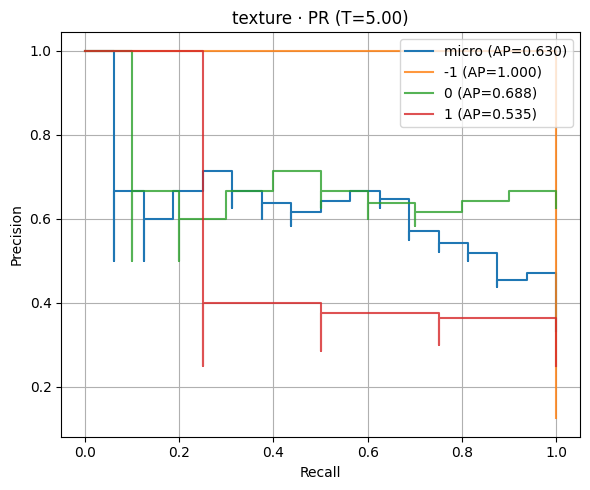

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 4, 0: 33, 1: 12} | y_va: {-1: 2, 0: 6, 1: 4} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.429  val_macroF1[TTA]=0.178
Warm 2/3 — tr_acc=0.633  val_macroF1[TTA]=0.178
Warm 3/3 — tr_acc=0.612  val_macroF1[TTA]=0.216

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.449  val_macroF1[TTA]=0.277
FT 2/15 — tr_acc=0.592  val_macroF1[TTA]=0.178
FT 3/15 — tr_acc=0.551  val_macroF1[TTA]=0.222
FT 4/15 — tr_acc=0.673  val_macroF1[TTA]=0.273
FT 5/15 — tr_acc=0.633  val_macroF1[TTA]=0.357
FT 6/15 — tr_acc=0.816  val_macroF1[TTA]=0.389
FT 7/15 — tr_acc=0.857  val_macroF1[TTA]=0.222
FT 8/15 — tr_acc=0.918  val_macroF1[TTA]=0.367
FT 9/15 — tr_acc=0.776  val_macroF1[TTA]=0.369
FT 10/15 — tr_acc=0.918  val_macroF1[TTA]=0.369
FT 11/15 — tr_acc=0.9

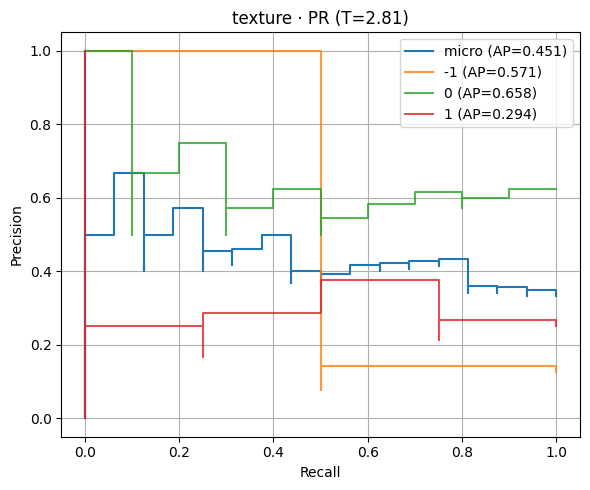

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 4, 0: 32, 1: 12} | y_va: {-1: 2, 0: 7, 1: 4} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.375  val_macroF1[TTA]=0.356
Warm 2/3 — tr_acc=0.479  val_macroF1[TTA]=0.233
Warm 3/3 — tr_acc=0.771  val_macroF1[TTA]=0.321

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.396  val_macroF1[TTA]=0.089
FT 2/15 — tr_acc=0.521  val_macroF1[TTA]=0.233
FT 3/15 — tr_acc=0.438  val_macroF1[TTA]=0.167
FT 4/15 — tr_acc=0.333  val_macroF1[TTA]=0.422
FT 5/15 — tr_acc=0.625  val_macroF1[TTA]=0.190
FT 6/15 — tr_acc=0.500  val_macroF1[TTA]=0.232
FT 7/15 — tr_acc=0.688  val_macroF1[TTA]=0.233
FT 8/15 — tr_acc=0.771  val_macroF1[TTA]=0.419
FT 9/15 — tr_acc=0.729  val_macroF1[TTA]=0.371
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


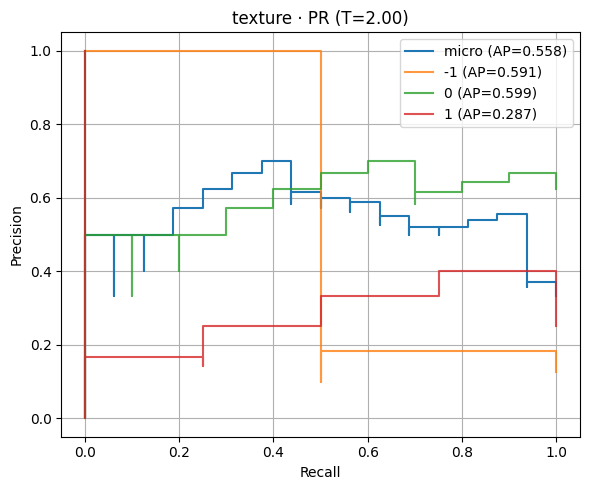

texture | 3 runs → mean=0.296 ± 0.068 (min=0.240, max=0.393)
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 9, 0: 63, 1: 23} | y_va: {-1: 2, 0: 8, 1: 6} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.379  val_macroF1[TTA]=0.111
Warm 2/3 — tr_acc=0.558  val_macroF1[TTA]=0.324
Warm 3/3 — tr_acc=0.537  val_macroF1[TTA]=0.366

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.432  val_macroF1[TTA]=0.233
FT 2/15 — tr_acc=0.558  val_macroF1[TTA]=0.222
FT 3/15 — tr_acc=0.495  val_macroF1[TTA]=0.229
FT 4/15 — tr_acc=0.705  val_macroF1[TTA]=0.133
FT 5/15 — tr_acc=0.716  val_macroF1[TTA]=0.220
FT 6/15 — tr_acc=0.895  val_macroF1[TTA]=0.093
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 4.454

[texture] Test (TTA+TS) — macro-F1=0.256 | weighted-F1=0.481 | acc=0.6

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


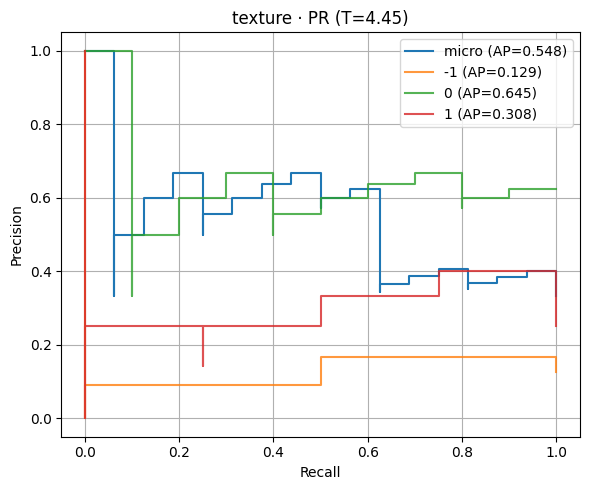

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 9, 0: 61, 1: 22} | y_va: {-1: 2, 0: 10, 1: 7} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.413  val_macroF1[TTA]=0.236
Warm 2/3 — tr_acc=0.435  val_macroF1[TTA]=0.247
Warm 3/3 — tr_acc=0.554  val_macroF1[TTA]=0.257

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.391  val_macroF1[TTA]=0.063
FT 2/15 — tr_acc=0.304  val_macroF1[TTA]=0.222
FT 3/15 — tr_acc=0.609  val_macroF1[TTA]=0.367
FT 4/15 — tr_acc=0.598  val_macroF1[TTA]=0.395
FT 5/15 — tr_acc=0.717  val_macroF1[TTA]=0.229
FT 6/15 — tr_acc=0.815  val_macroF1[TTA]=0.357
FT 7/15 — tr_acc=0.924  val_macroF1[TTA]=0.336
FT 8/15 — tr_acc=0.946  val_macroF1[TTA]=0.333
FT 9/15 — tr_acc=0.913  val_macroF1[TTA]=0.276
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


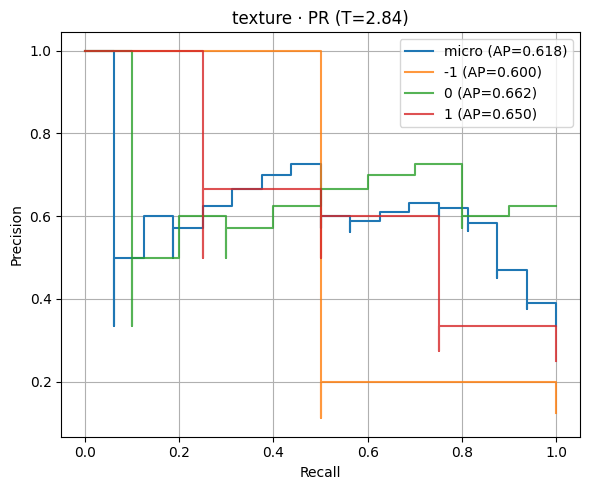

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 9, 0: 57, 1: 26} | y_va: {-1: 2, 0: 14, 1: 3} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.348  val_macroF1[TTA]=0.280
Warm 2/3 — tr_acc=0.587  val_macroF1[TTA]=0.074
Warm 3/3 — tr_acc=0.587  val_macroF1[TTA]=0.396

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.359  val_macroF1[TTA]=0.271
FT 2/15 — tr_acc=0.391  val_macroF1[TTA]=0.091
FT 3/15 — tr_acc=0.641  val_macroF1[TTA]=0.137
FT 4/15 — tr_acc=0.565  val_macroF1[TTA]=0.205
FT 5/15 — tr_acc=0.793  val_macroF1[TTA]=0.240
FT 6/15 — tr_acc=0.826  val_macroF1[TTA]=0.256
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 1.384

[texture] Test (TTA+TS) — macro-F1=0.256 | weighted-F1=0.481 | acc=0.625 | MCC=0.000 | QWK=0.000 | Top-2=0.875 | AUROC(micro/macro

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


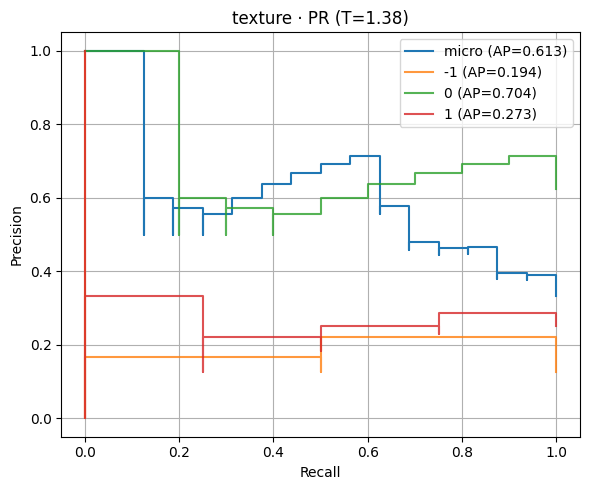

texture | 3 runs → mean=0.251 ± 0.008 (min=0.240, max=0.256)


In [23]:
if __name__ == "__main__":
    #_init_results_csv()
    # single-feature
    repeat_avg(feature="texture", n_runs=3, base_seed=42, use_synthetic=False)
    repeat_avg(feature="texture", n_runs=3, base_seed=42, use_synthetic=True)


==== use_synthetic=False ====
→ Training feature: oiliness  | runs=3  | base_seed=2025


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 48, 1: 2} | y_va: {0: 10, 1: 1} | y_te: {0: 14, 1: 2}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.760  val_macroF1[TTA]=0.476
Warm 2/3 — tr_acc=0.700  val_macroF1[TTA]=0.476
Warm 3/3 — tr_acc=0.920  val_macroF1[TTA]=0.450

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.580  val_macroF1[TTA]=0.476
FT 2/15 — tr_acc=0.800  val_macroF1[TTA]=0.476
FT 3/15 — tr_acc=0.880  val_macroF1[TTA]=0.450
FT 4/15 — tr_acc=0.960  val_macroF1[TTA]=0.421
FT 5/15 — tr_acc=0.980  val_macroF1[TTA]=0.421
FT 6/15 — tr_acc=0.980  val_macroF1[TTA]=0.476
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 3.547
Tuned threshold (TTA+TS) on val: 0.200

[oiliness] Test (TTA+TS) — macro-F1=0.467 | weighted-F1=0.817 | acc=0.875 | MCC=0.000 | QWK=0.000 | AUROC=0.321
 

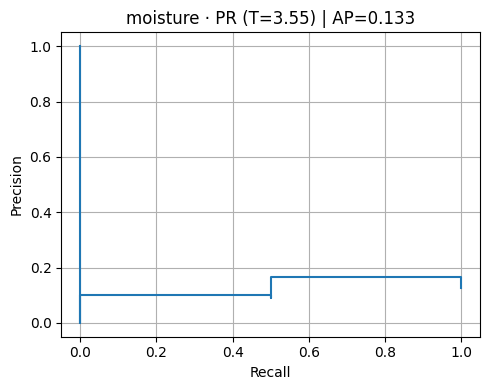

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 48, 1: 2} | y_va: {0: 10, 1: 1} | y_te: {0: 14, 1: 2}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.660  val_macroF1[TTA]=0.450
Warm 2/3 — tr_acc=0.820  val_macroF1[TTA]=0.450
Warm 3/3 — tr_acc=0.860  val_macroF1[TTA]=0.476

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.660  val_macroF1[TTA]=0.476
FT 2/15 — tr_acc=0.620  val_macroF1[TTA]=0.476
FT 3/15 — tr_acc=0.860  val_macroF1[TTA]=0.476
FT 4/15 — tr_acc=0.980  val_macroF1[TTA]=0.450
FT 5/15 — tr_acc=0.940  val_macroF1[TTA]=0.476
FT 6/15 — tr_acc=1.000  val_macroF1[TTA]=0.476
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 2.909
Tuned threshold (TTA+TS) on val: 0.200

[oiliness] Test (TTA+TS) — macro-F1=0.467 | weighted-F1=0.817 | acc=0.875 | MCC=0.000 | QWK=0.000 | AUROC=0.464
 

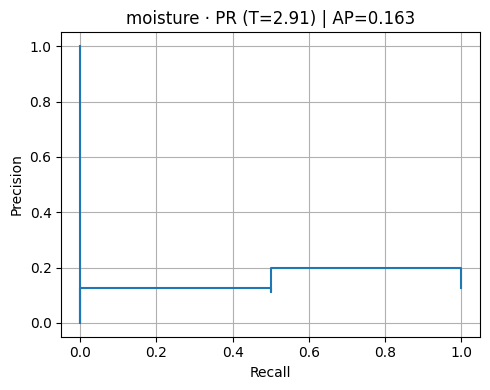

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 48, 1: 2} | y_va: {0: 10, 1: 1} | y_te: {0: 14, 1: 2}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.820  val_macroF1[TTA]=0.450
Warm 2/3 — tr_acc=0.900  val_macroF1[TTA]=0.450
Warm 3/3 — tr_acc=0.880  val_macroF1[TTA]=0.476

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.620  val_macroF1[TTA]=0.476
FT 2/15 — tr_acc=0.520  val_macroF1[TTA]=0.476
FT 3/15 — tr_acc=0.680  val_macroF1[TTA]=0.450
FT 4/15 — tr_acc=0.780  val_macroF1[TTA]=0.450
FT 5/15 — tr_acc=0.980  val_macroF1[TTA]=0.450
FT 6/15 — tr_acc=0.940  val_macroF1[TTA]=0.476
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 3.047
Tuned threshold (TTA+TS) on val: 0.200

[oiliness] Test (TTA+TS) — macro-F1=0.467 | weighted-F1=0.817 | acc=0.875 | MCC=0.000 | QWK=0.000 | AUROC=0.321
 

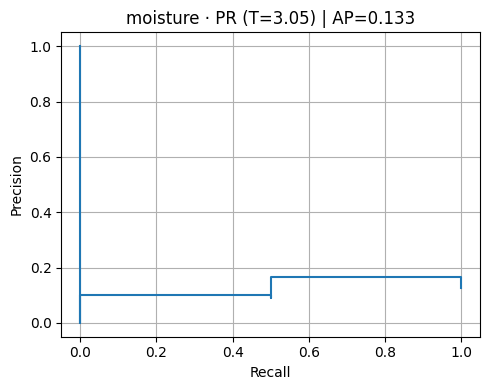

oiliness | backbone=dinov2_b14 | use_synthetic=False | 3 runs → mean=0.467 ± 0.000 (min=0.467, max=0.467)
→ Training feature: moisture  | runs=3  | base_seed=2025
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 35, 1: 15} | y_va: {0: 7, 1: 4} | y_te: {0: 10, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.400  val_macroF1[TTA]=0.389
Warm 2/3 — tr_acc=0.480  val_macroF1[TTA]=0.389
Warm 3/3 — tr_acc=0.720  val_macroF1[TTA]=0.389

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.480  val_macroF1[TTA]=0.267
FT 2/15 — tr_acc=0.380  val_macroF1[TTA]=0.389
FT 3/15 — tr_acc=0.560  val_macroF1[TTA]=0.389
FT 4/15 — tr_acc=0.620  val_macroF1[TTA]=0.389
FT 5/15 — tr_acc=0.520  val_macroF1[TTA]=0.612
FT 6/15 — tr_acc=0.520  val_macroF1[TTA]=0.450
FT 7/15 — tr_acc=0.480  val_macroF1[TTA]=0.389
FT 8/15 — tr_acc=0.80

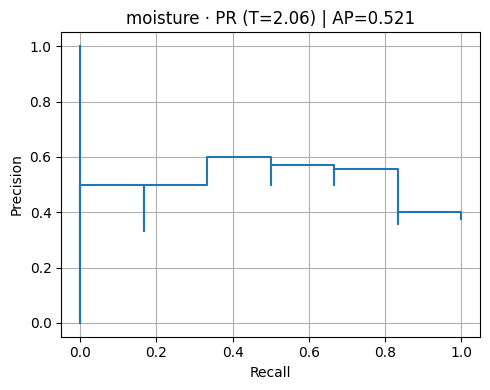

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 32, 1: 17} | y_va: {0: 10, 1: 2} | y_te: {0: 10, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.571  val_macroF1[TTA]=0.455
Warm 2/3 — tr_acc=0.612  val_macroF1[TTA]=0.455
Warm 3/3 — tr_acc=0.490  val_macroF1[TTA]=0.413

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.490  val_macroF1[TTA]=0.455
FT 2/15 — tr_acc=0.490  val_macroF1[TTA]=0.455
FT 3/15 — tr_acc=0.571  val_macroF1[TTA]=0.455
FT 4/15 — tr_acc=0.510  val_macroF1[TTA]=0.143
FT 5/15 — tr_acc=0.673  val_macroF1[TTA]=0.455
FT 6/15 — tr_acc=0.531  val_macroF1[TTA]=0.143
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 1.600
Tuned threshold (TTA+TS) on val: 0.220

[moisture] Test (TTA+TS) — macro-F1=0.385 | weighted-F1=0.481 | acc=0.625 | MCC=0.000 | QWK=0.000 | AUROC=0.617


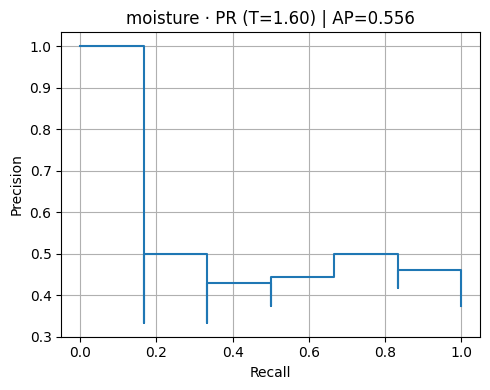

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 31, 1: 17} | y_va: {0: 11, 1: 2} | y_te: {0: 10, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.562  val_macroF1[TTA]=0.458
Warm 2/3 — tr_acc=0.625  val_macroF1[TTA]=0.458
Warm 3/3 — tr_acc=0.646  val_macroF1[TTA]=0.458

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.562  val_macroF1[TTA]=0.707
FT 2/15 — tr_acc=0.542  val_macroF1[TTA]=0.133
FT 3/15 — tr_acc=0.500  val_macroF1[TTA]=0.458
FT 4/15 — tr_acc=0.500  val_macroF1[TTA]=0.458
FT 5/15 — tr_acc=0.542  val_macroF1[TTA]=0.458
FT 6/15 — tr_acc=0.396  val_macroF1[TTA]=0.133
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 0.500
Tuned threshold (TTA+TS) on val: 0.560

[moisture] Test (TTA+TS) — macro-F1=0.500 | weighted-F1=0.562 | acc=0.625 | MCC=0.098 | QWK=0.077 | AUROC=0.533


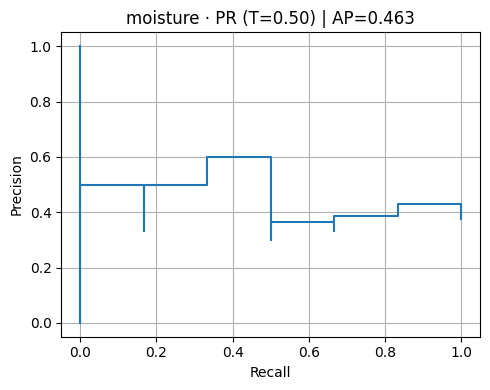

moisture | backbone=dinov2_b14 | use_synthetic=False | 3 runs → mean=0.503 ± 0.120 (min=0.385, max=0.625)
→ Training feature: texture  | runs=3  | base_seed=2025
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 4, 0: 32, 1: 12} | y_va: {-1: 2, 0: 7, 1: 4} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.438  val_macroF1[TTA]=0.233
Warm 2/3 — tr_acc=0.458  val_macroF1[TTA]=0.236
Warm 3/3 — tr_acc=0.479  val_macroF1[TTA]=0.343

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.333  val_macroF1[TTA]=0.157
FT 2/15 — tr_acc=0.458  val_macroF1[TTA]=0.157
FT 3/15 — tr_acc=0.417  val_macroF1[TTA]=0.157
FT 4/15 — tr_acc=0.292  val_macroF1[TTA]=0.089
FT 5/15 — tr_acc=0.458  val_macroF1[TTA]=0.233
FT 6/15 — tr_acc=0.312  val_macroF1[TTA]=0.157
FT 7/15 — tr_acc=0.271  val_macroF1[TTA]=0.233
F

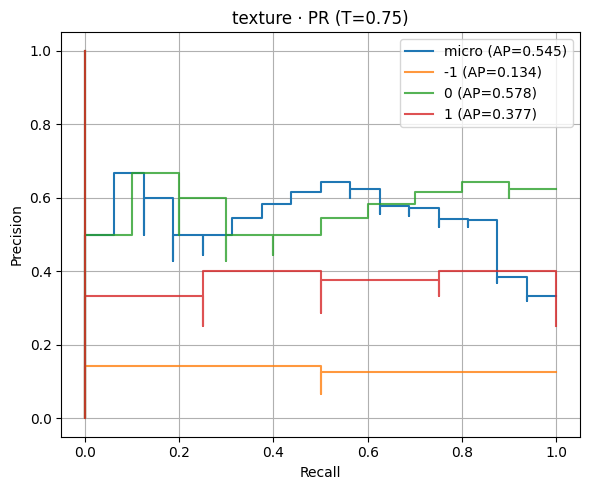

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 4, 0: 32, 1: 14} | y_va: {-1: 2, 0: 7, 1: 2} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.520  val_macroF1[TTA]=0.074
Warm 2/3 — tr_acc=0.600  val_macroF1[TTA]=0.250
Warm 3/3 — tr_acc=0.360  val_macroF1[TTA]=0.259

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.420  val_macroF1[TTA]=0.103
FT 2/15 — tr_acc=0.320  val_macroF1[TTA]=0.103
FT 3/15 — tr_acc=0.140  val_macroF1[TTA]=0.259
FT 4/15 — tr_acc=0.500  val_macroF1[TTA]=0.259
FT 5/15 — tr_acc=0.460  val_macroF1[TTA]=0.103
FT 6/15 — tr_acc=0.360  val_macroF1[TTA]=0.194
FT 7/15 — tr_acc=0.380  val_macroF1[TTA]=0.103
FT 8/15 — tr_acc=0.440  val_macroF1[TTA]=0.259
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 3.407

[texture] Test (TTA+TS) — macro-F1=0.

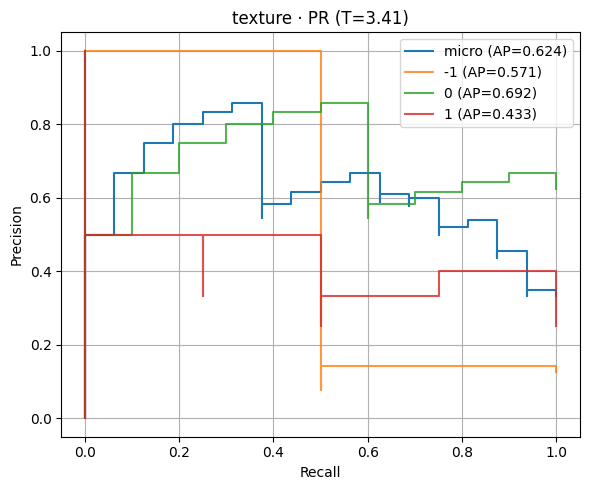

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 4, 0: 31, 1: 12} | y_va: {-1: 2, 0: 8, 1: 4} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.234  val_macroF1[TTA]=0.222
Warm 2/3 — tr_acc=0.511  val_macroF1[TTA]=0.148
Warm 3/3 — tr_acc=0.596  val_macroF1[TTA]=0.083

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.404  val_macroF1[TTA]=0.148
FT 2/15 — tr_acc=0.340  val_macroF1[TTA]=0.242
FT 3/15 — tr_acc=0.489  val_macroF1[TTA]=0.242
FT 4/15 — tr_acc=0.213  val_macroF1[TTA]=0.083
FT 5/15 — tr_acc=0.362  val_macroF1[TTA]=0.083
FT 6/15 — tr_acc=0.660  val_macroF1[TTA]=0.148
FT 7/15 — tr_acc=0.277  val_macroF1[TTA]=0.083
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 1.886

[texture] Test (TTA+TS) — macro-F1=0.256 | weighted-F1=0.481 | acc=0.625 | MCC=0.000

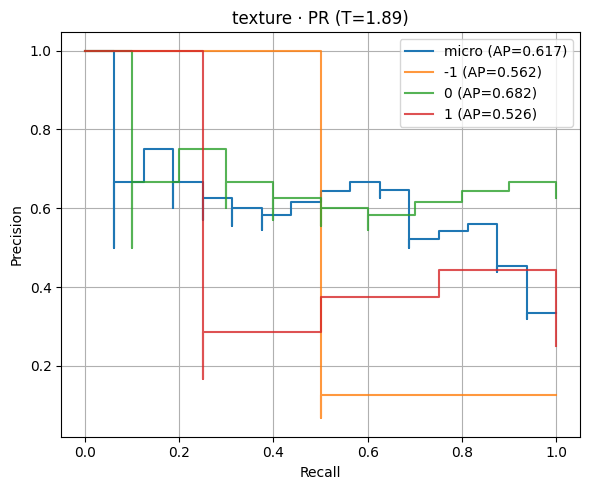

texture | backbone=dinov2_b14 | use_synthetic=False | 3 runs → mean=0.256 ± 0.000 (min=0.256, max=0.256)
→ Training feature: elasticity  | runs=3  | base_seed=2025
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 2, 0: 30, 1: 13} | y_va: {-1: 2, 0: 12, 1: 2} | y_te: {-1: 2, 0: 6, 1: 8}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.311  val_macroF1[TTA]=0.130
Warm 2/3 — tr_acc=0.578  val_macroF1[TTA]=0.133
Warm 3/3 — tr_acc=0.689  val_macroF1[TTA]=0.111

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.422  val_macroF1[TTA]=0.203
FT 2/15 — tr_acc=0.600  val_macroF1[TTA]=0.203
FT 3/15 — tr_acc=0.489  val_macroF1[TTA]=0.203
FT 4/15 — tr_acc=0.644  val_macroF1[TTA]=0.074
FT 5/15 — tr_acc=0.467  val_macroF1[TTA]=0.256
FT 6/15 — tr_acc=0.689  val_macroF1[TTA]=0.074
FT 7/15 — tr_acc=0.600  val_macroF1[TTA]=0.203

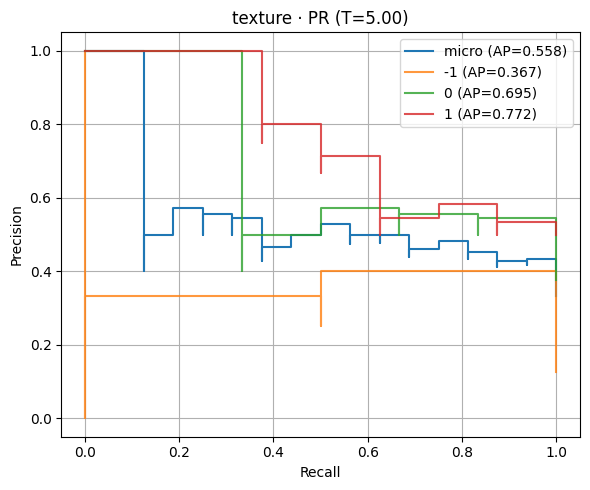

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 2, 0: 34, 1: 12} | y_va: {-1: 2, 0: 8, 1: 3} | y_te: {-1: 2, 0: 6, 1: 8}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.208  val_macroF1[TTA]=0.254
Warm 2/3 — tr_acc=0.708  val_macroF1[TTA]=0.095
Warm 3/3 — tr_acc=0.438  val_macroF1[TTA]=0.254

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.396  val_macroF1[TTA]=0.254
FT 2/15 — tr_acc=0.396  val_macroF1[TTA]=0.254
FT 3/15 — tr_acc=0.708  val_macroF1[TTA]=0.125
FT 4/15 — tr_acc=0.417  val_macroF1[TTA]=0.254
FT 5/15 — tr_acc=0.688  val_macroF1[TTA]=0.254
FT 6/15 — tr_acc=0.708  val_macroF1[TTA]=0.089
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 2.810

[elasticity] Test (TTA+TS) — macro-F1=0.182 | weighted-F1=0.205 | acc=0.375 | MCC=0.000 | QWK=0.000 | Top-2=0.875 | AUROC(micro/macr

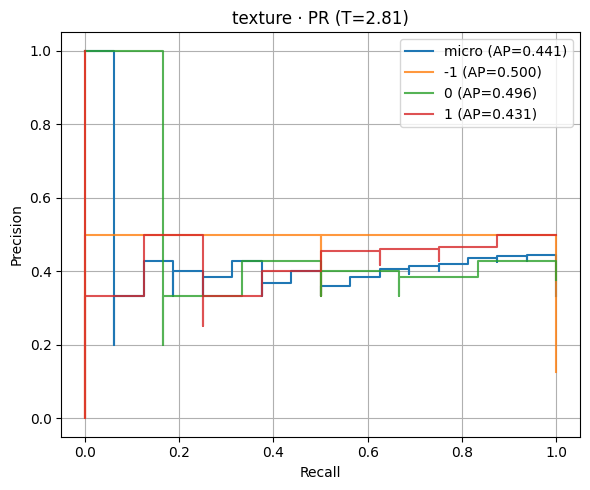

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 2, 0: 36, 1: 12} | y_va: {-1: 2, 0: 6, 1: 3} | y_te: {-1: 2, 0: 6, 1: 8}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.420  val_macroF1[TTA]=0.235
Warm 2/3 — tr_acc=0.620  val_macroF1[TTA]=0.143
Warm 3/3 — tr_acc=0.680  val_macroF1[TTA]=0.205

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.480  val_macroF1[TTA]=0.135
FT 2/15 — tr_acc=0.480  val_macroF1[TTA]=0.143
FT 3/15 — tr_acc=0.440  val_macroF1[TTA]=0.143
FT 4/15 — tr_acc=0.500  val_macroF1[TTA]=0.235
FT 5/15 — tr_acc=0.380  val_macroF1[TTA]=0.235
FT 6/15 — tr_acc=0.700  val_macroF1[TTA]=0.235
FT 7/15 — tr_acc=0.560  val_macroF1[TTA]=0.143
FT 8/15 — tr_acc=0.540  val_macroF1[TTA]=0.235
FT 9/15 — tr_acc=0.660  val_macroF1[TTA]=0.235
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T 

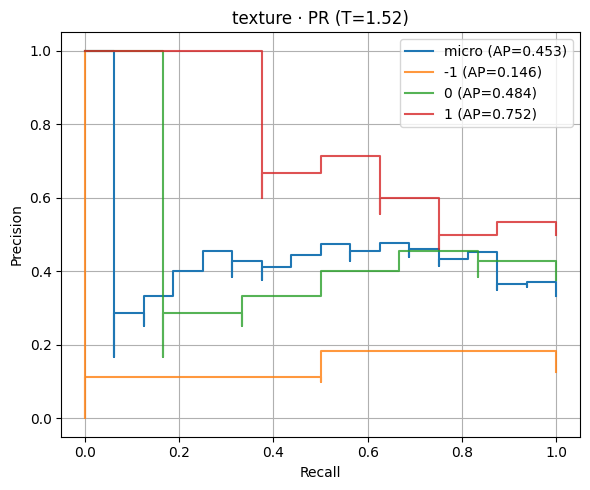

elasticity | backbone=dinov2_b14 | use_synthetic=False | 3 runs → mean=0.232 ± 0.087 (min=0.182, max=0.333)
→ Training feature: hyperpigmentation  | runs=3  | base_seed=2025
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 4, 0: 28, 1: 16} | y_va: {-1: 2, 0: 8, 1: 3} | y_te: {-1: 2, 0: 8, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.479  val_macroF1[TTA]=0.276
Warm 2/3 — tr_acc=0.500  val_macroF1[TTA]=0.222
Warm 3/3 — tr_acc=0.583  val_macroF1[TTA]=0.276

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.312  val_macroF1[TTA]=0.125
FT 2/15 — tr_acc=0.562  val_macroF1[TTA]=0.125
FT 3/15 — tr_acc=0.208  val_macroF1[TTA]=0.125
FT 4/15 — tr_acc=0.479  val_macroF1[TTA]=0.125
FT 5/15 — tr_acc=0.292  val_macroF1[TTA]=0.125
FT 6/15 — tr_acc=0.333  val_macroF1[TTA]=0.125
Early stopping on val macro-F1 (TTA).

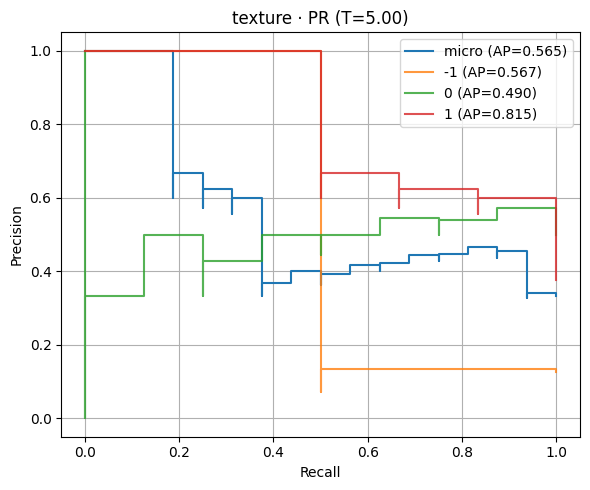

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 4, 0: 32, 1: 12} | y_va: {-1: 2, 0: 4, 1: 7} | y_te: {-1: 2, 0: 8, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.542  val_macroF1[TTA]=0.233
Warm 2/3 — tr_acc=0.562  val_macroF1[TTA]=0.157
Warm 3/3 — tr_acc=0.625  val_macroF1[TTA]=0.157

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.354  val_macroF1[TTA]=0.089
FT 2/15 — tr_acc=0.312  val_macroF1[TTA]=0.415
FT 3/15 — tr_acc=0.688  val_macroF1[TTA]=0.233
FT 4/15 — tr_acc=0.438  val_macroF1[TTA]=0.457
FT 5/15 — tr_acc=0.396  val_macroF1[TTA]=0.455
FT 6/15 — tr_acc=0.521  val_macroF1[TTA]=0.233
FT 7/15 — tr_acc=0.438  val_macroF1[TTA]=0.157
FT 8/15 — tr_acc=0.583  val_macroF1[TTA]=0.408
FT 9/15 — tr_acc=0.354  val_macroF1[TTA]=0.246
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T 

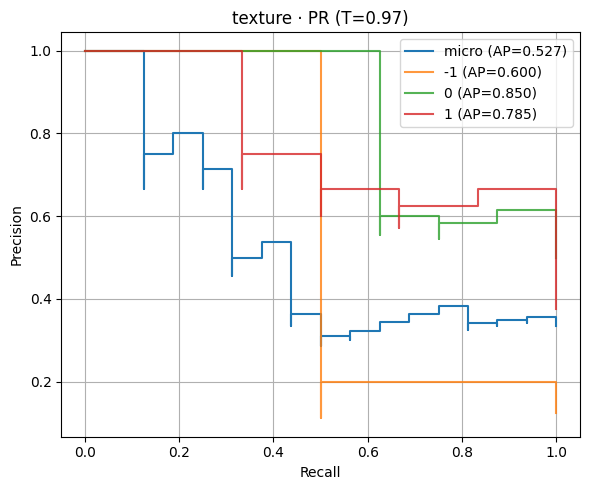

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 4, 0: 32, 1: 12} | y_va: {-1: 2, 0: 4, 1: 7} | y_te: {-1: 2, 0: 8, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.479  val_macroF1[TTA]=0.229
Warm 2/3 — tr_acc=0.604  val_macroF1[TTA]=0.252
Warm 3/3 — tr_acc=0.833  val_macroF1[TTA]=0.233

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.417  val_macroF1[TTA]=0.233
FT 2/15 — tr_acc=0.438  val_macroF1[TTA]=0.370
FT 3/15 — tr_acc=0.500  val_macroF1[TTA]=0.242
FT 4/15 — tr_acc=0.521  val_macroF1[TTA]=0.379
FT 5/15 — tr_acc=0.479  val_macroF1[TTA]=0.214
FT 6/15 — tr_acc=0.521  val_macroF1[TTA]=0.326
FT 7/15 — tr_acc=0.583  val_macroF1[TTA]=0.353
FT 8/15 — tr_acc=0.667  val_macroF1[TTA]=0.456
FT 9/15 — tr_acc=0.604  val_macroF1[TTA]=0.558
FT 10/15 — tr_acc=0.833  val_macroF1[TTA]=0.278
FT 11/15 — tr_acc=0.81

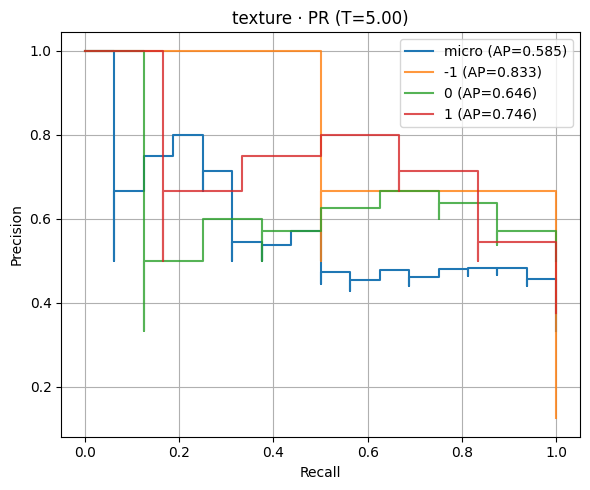

hyperpigmentation | backbone=dinov2_b14 | use_synthetic=False | 3 runs → mean=0.323 ± 0.137 (min=0.182, max=0.456)

==== use_synthetic=True ====
→ Training feature: oiliness  | runs=3  | base_seed=2025
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 84, 1: 4} | y_va: {0: 21, 1: 2} | y_te: {0: 14, 1: 2}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.693  val_macroF1[TTA]=0.517
Warm 2/3 — tr_acc=0.875  val_macroF1[TTA]=0.238
Warm 3/3 — tr_acc=0.886  val_macroF1[TTA]=0.808

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.659  val_macroF1[TTA]=0.477
FT 2/15 — tr_acc=0.864  val_macroF1[TTA]=0.465
FT 3/15 — tr_acc=0.943  val_macroF1[TTA]=0.465
FT 4/15 — tr_acc=1.000  val_macroF1[TTA]=0.452
FT 5/15 — tr_acc=0.989  val_macroF1[TTA]=0.465
FT 6/15 — tr_acc=1.000  val_macroF1[TTA]=0.465
Early stopping on val macro-F

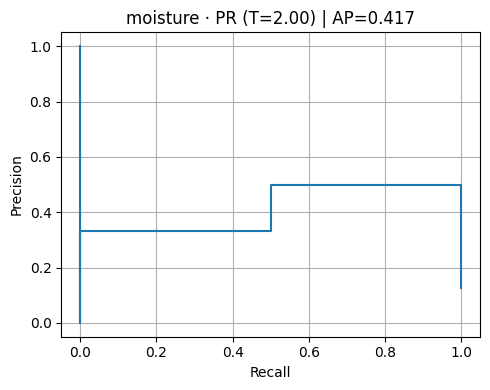

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 87, 1: 4} | y_va: {0: 18, 1: 2} | y_te: {0: 14, 1: 2}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.593  val_macroF1[TTA]=0.091
Warm 2/3 — tr_acc=0.758  val_macroF1[TTA]=0.820
Warm 3/3 — tr_acc=0.901  val_macroF1[TTA]=0.722

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.604  val_macroF1[TTA]=0.474
FT 2/15 — tr_acc=0.769  val_macroF1[TTA]=0.567
FT 3/15 — tr_acc=0.923  val_macroF1[TTA]=0.688
FT 4/15 — tr_acc=0.956  val_macroF1[TTA]=0.722
FT 5/15 — tr_acc=0.978  val_macroF1[TTA]=0.820
FT 6/15 — tr_acc=0.989  val_macroF1[TTA]=0.820
FT 7/15 — tr_acc=1.000  val_macroF1[TTA]=0.820
FT 8/15 — tr_acc=1.000  val_macroF1[TTA]=0.820
FT 9/15 — tr_acc=1.000  val_macroF1[TTA]=0.820
FT 10/15 — tr_acc=0.989  val_macroF1[TTA]=0.820
Early stopping on val macro-F1 (TTA).
Fitt

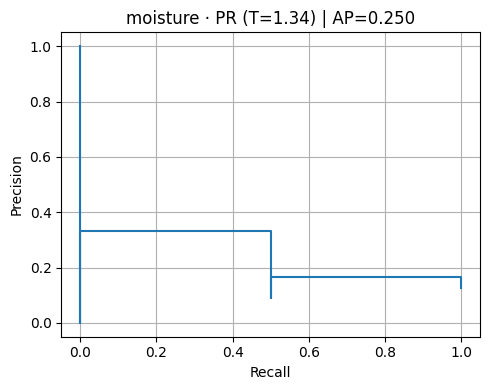

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 89, 1: 4} | y_va: {0: 16, 1: 2} | y_te: {0: 14, 1: 2}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.731  val_macroF1[TTA]=0.471
Warm 2/3 — tr_acc=0.882  val_macroF1[TTA]=0.818
Warm 3/3 — tr_acc=0.935  val_macroF1[TTA]=0.719

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.645  val_macroF1[TTA]=0.100
FT 2/15 — tr_acc=0.710  val_macroF1[TTA]=0.818
FT 3/15 — tr_acc=0.882  val_macroF1[TTA]=0.818
FT 4/15 — tr_acc=0.957  val_macroF1[TTA]=0.818
FT 5/15 — tr_acc=0.957  val_macroF1[TTA]=0.818
FT 6/15 — tr_acc=1.000  val_macroF1[TTA]=0.818
FT 7/15 — tr_acc=1.000  val_macroF1[TTA]=0.818
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 2.262
Tuned threshold (TTA+TS) on val: 0.400

[oiliness] Test (TTA+TS) — macro-F1=0.467 | weighted-F1=0.817 | ac

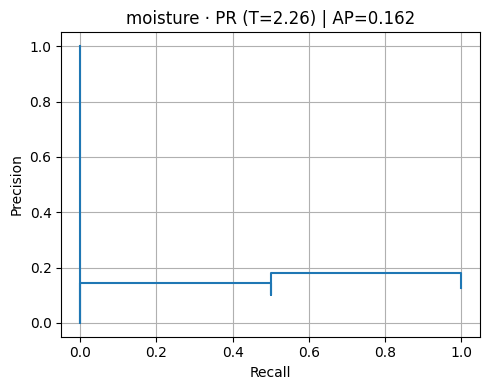

oiliness | backbone=dinov2_b14 | use_synthetic=True | 3 runs → mean=0.467 ± 0.000 (min=0.467, max=0.467)
→ Training feature: moisture  | runs=3  | base_seed=2025
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 62, 1: 31} | y_va: {0: 14, 1: 4} | y_te: {0: 10, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.559  val_macroF1[TTA]=0.438
Warm 2/3 — tr_acc=0.624  val_macroF1[TTA]=0.182
Warm 3/3 — tr_acc=0.527  val_macroF1[TTA]=0.325

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.602  val_macroF1[TTA]=0.438
FT 2/15 — tr_acc=0.538  val_macroF1[TTA]=0.182
FT 3/15 — tr_acc=0.462  val_macroF1[TTA]=0.585
FT 4/15 — tr_acc=0.613  val_macroF1[TTA]=0.325
FT 5/15 — tr_acc=0.559  val_macroF1[TTA]=0.438
FT 6/15 — tr_acc=0.484  val_macroF1[TTA]=0.734
FT 7/15 — tr_acc=0.624  val_macroF1[TTA]=0.498
FT 8/15 — tr_acc=0.69

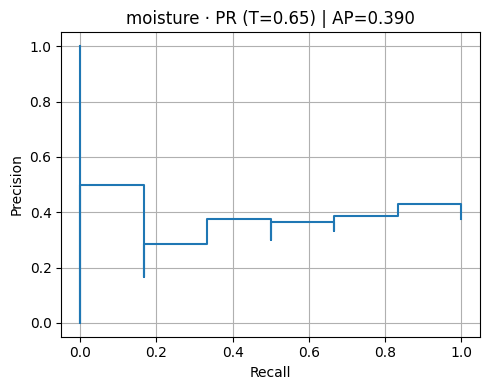

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 66, 1: 26} | y_va: {0: 10, 1: 9} | y_te: {0: 10, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.511  val_macroF1[TTA]=0.474
Warm 2/3 — tr_acc=0.663  val_macroF1[TTA]=0.424
Warm 3/3 — tr_acc=0.772  val_macroF1[TTA]=0.321

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.500  val_macroF1[TTA]=0.321
FT 2/15 — tr_acc=0.478  val_macroF1[TTA]=0.345
FT 3/15 — tr_acc=0.598  val_macroF1[TTA]=0.345
FT 4/15 — tr_acc=0.609  val_macroF1[TTA]=0.460
FT 5/15 — tr_acc=0.652  val_macroF1[TTA]=0.472
FT 6/15 — tr_acc=0.728  val_macroF1[TTA]=0.552
FT 7/15 — tr_acc=0.837  val_macroF1[TTA]=0.548
FT 8/15 — tr_acc=0.957  val_macroF1[TTA]=0.345
FT 9/15 — tr_acc=0.891  val_macroF1[TTA]=0.548
FT 10/15 — tr_acc=0.739  val_macroF1[TTA]=0.321
FT 11/15 — tr_acc=0.641  val_macroF1[TTA]

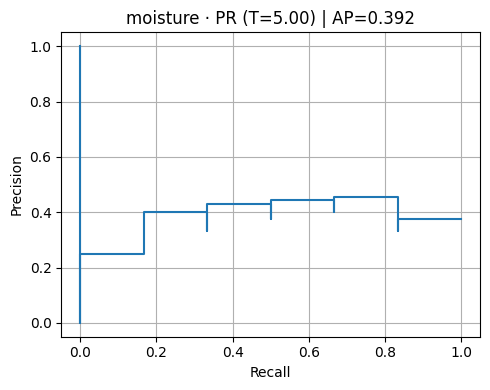

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {0: 65, 1: 28} | y_va: {0: 11, 1: 7} | y_te: {0: 10, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.527  val_macroF1[TTA]=0.379
Warm 2/3 — tr_acc=0.602  val_macroF1[TTA]=0.375
Warm 3/3 — tr_acc=0.699  val_macroF1[TTA]=0.579

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.645  val_macroF1[TTA]=0.446
FT 2/15 — tr_acc=0.624  val_macroF1[TTA]=0.481
FT 3/15 — tr_acc=0.688  val_macroF1[TTA]=0.532
FT 4/15 — tr_acc=0.763  val_macroF1[TTA]=0.379
FT 5/15 — tr_acc=0.667  val_macroF1[TTA]=0.357
FT 6/15 — tr_acc=0.806  val_macroF1[TTA]=0.379
FT 7/15 — tr_acc=0.828  val_macroF1[TTA]=0.625
FT 8/15 — tr_acc=0.935  val_macroF1[TTA]=0.649
FT 9/15 — tr_acc=0.882  val_macroF1[TTA]=0.723
FT 10/15 — tr_acc=0.892  val_macroF1[TTA]=0.600
FT 11/15 — tr_acc=0.978  val_macroF1[TTA]

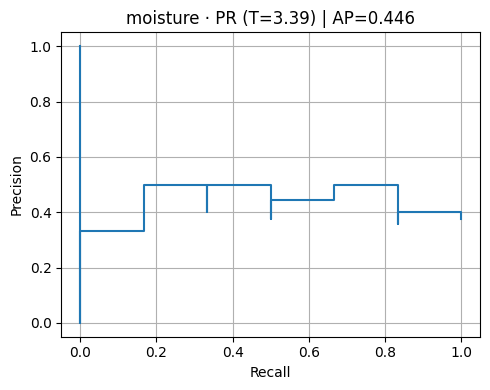

moisture | backbone=dinov2_b14 | use_synthetic=True | 3 runs → mean=0.522 ± 0.093 (min=0.418, max=0.600)
→ Training feature: texture  | runs=3  | base_seed=2025
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 9, 0: 59, 1: 25} | y_va: {-1: 2, 0: 12, 1: 4} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.419  val_macroF1[TTA]=0.114
Warm 2/3 — tr_acc=0.452  val_macroF1[TTA]=0.314
Warm 3/3 — tr_acc=0.462  val_macroF1[TTA]=0.222

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.387  val_macroF1[TTA]=0.067
FT 2/15 — tr_acc=0.398  val_macroF1[TTA]=0.067
FT 3/15 — tr_acc=0.452  val_macroF1[TTA]=0.267
FT 4/15 — tr_acc=0.301  val_macroF1[TTA]=0.267
FT 5/15 — tr_acc=0.441  val_macroF1[TTA]=0.067
FT 6/15 — tr_acc=0.226  val_macroF1[TTA]=0.121
FT 7/15 — tr_acc=0.376  val_macroF1[TTA]=0.267
F

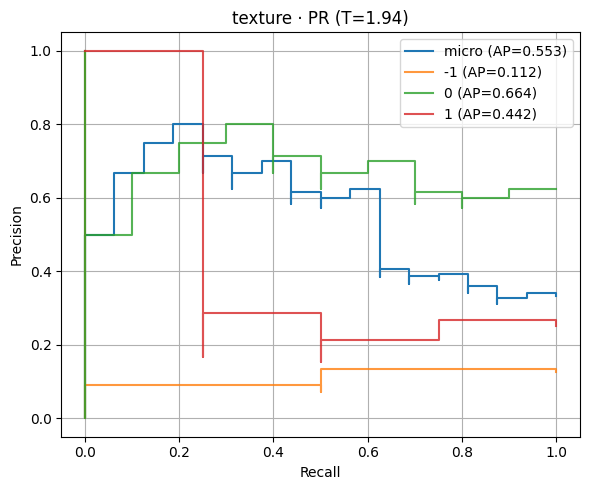

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 9, 0: 66, 1: 14} | y_va: {-1: 2, 0: 5, 1: 15} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.472  val_macroF1[TTA]=0.163
Warm 2/3 — tr_acc=0.539  val_macroF1[TTA]=0.350
Warm 3/3 — tr_acc=0.551  val_macroF1[TTA]=0.107

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.326  val_macroF1[TTA]=0.056
FT 2/15 — tr_acc=0.281  val_macroF1[TTA]=0.123
FT 3/15 — tr_acc=0.551  val_macroF1[TTA]=0.234
FT 4/15 — tr_acc=0.483  val_macroF1[TTA]=0.123
FT 5/15 — tr_acc=0.584  val_macroF1[TTA]=0.260
FT 6/15 — tr_acc=0.337  val_macroF1[TTA]=0.184
FT 7/15 — tr_acc=0.494  val_macroF1[TTA]=0.370
FT 8/15 — tr_acc=0.404  val_macroF1[TTA]=0.337
FT 9/15 — tr_acc=0.607  val_macroF1[TTA]=0.187
FT 10/15 — tr_acc=0.528  val_macroF1[TTA]=0.103
FT 11/15 — tr_acc=0.

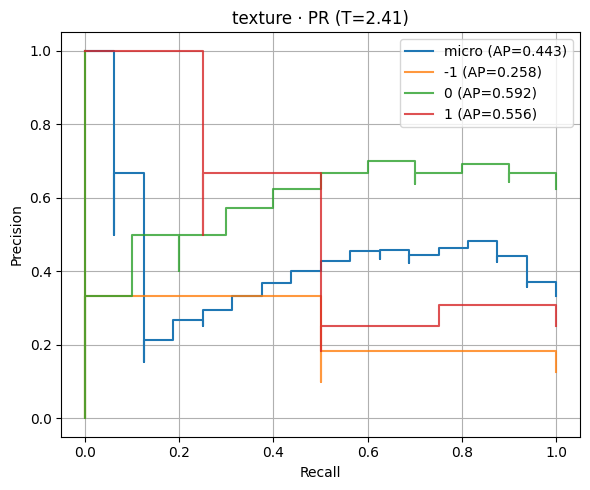

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 9, 0: 59, 1: 23} | y_va: {-1: 2, 0: 12, 1: 6} | y_te: {-1: 2, 0: 10, 1: 4}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.396  val_macroF1[TTA]=0.250
Warm 2/3 — tr_acc=0.429  val_macroF1[TTA]=0.237
Warm 3/3 — tr_acc=0.484  val_macroF1[TTA]=0.244

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.495  val_macroF1[TTA]=0.061
FT 2/15 — tr_acc=0.407  val_macroF1[TTA]=0.154
FT 3/15 — tr_acc=0.286  val_macroF1[TTA]=0.154
FT 4/15 — tr_acc=0.440  val_macroF1[TTA]=0.167
FT 5/15 — tr_acc=0.341  val_macroF1[TTA]=0.145
FT 6/15 — tr_acc=0.473  val_macroF1[TTA]=0.222
FT 7/15 — tr_acc=0.440  val_macroF1[TTA]=0.252
FT 8/15 — tr_acc=0.418  val_macroF1[TTA]=0.386
FT 9/15 — tr_acc=0.516  val_macroF1[TTA]=0.154
FT 10/15 — tr_acc=0.560  val_macroF1[TTA]=0.154
FT 11/15 — tr_acc=0.

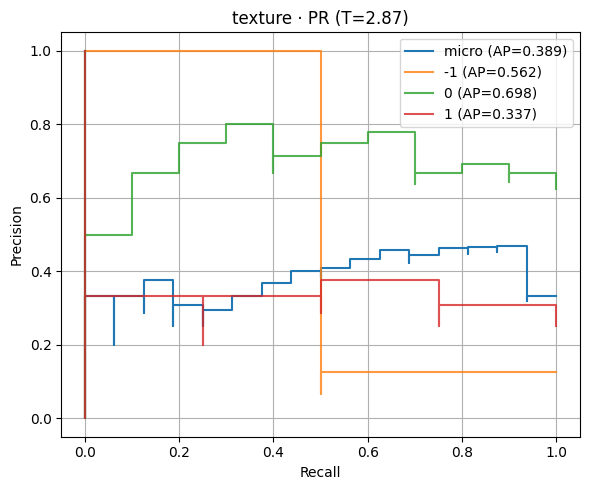

texture | backbone=dinov2_b14 | use_synthetic=True | 3 runs → mean=0.192 ± 0.059 (min=0.140, max=0.256)
→ Training feature: elasticity  | runs=3  | base_seed=2025
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 3, 0: 67, 1: 23} | y_va: {-1: 5, 0: 9, 1: 4} | y_te: {-1: 2, 0: 6, 1: 8}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.495  val_macroF1[TTA]=0.190
Warm 2/3 — tr_acc=0.538  val_macroF1[TTA]=0.222
Warm 3/3 — tr_acc=0.667  val_macroF1[TTA]=0.345

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.462  val_macroF1[TTA]=0.317
FT 2/15 — tr_acc=0.484  val_macroF1[TTA]=0.536
FT 3/15 — tr_acc=0.441  val_macroF1[TTA]=0.222
FT 4/15 — tr_acc=0.548  val_macroF1[TTA]=0.222
FT 5/15 — tr_acc=0.462  val_macroF1[TTA]=0.222
FT 6/15 — tr_acc=0.688  val_macroF1[TTA]=0.121
FT 7/15 — tr_acc=0.613  val_macroF1[TTA]=0.222
E

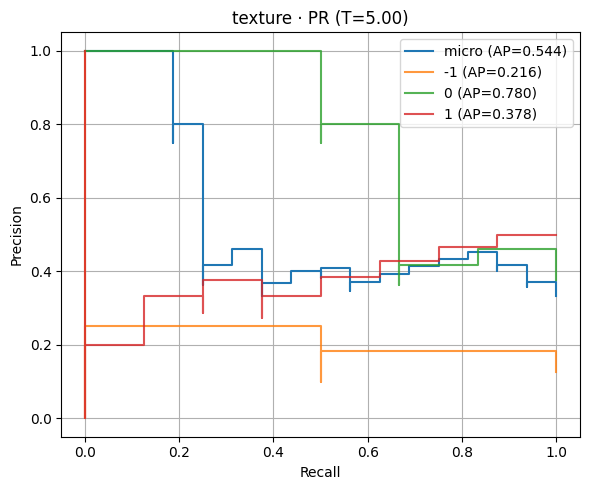

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 6, 0: 57, 1: 25} | y_va: {-1: 2, 0: 19, 1: 2} | y_te: {-1: 2, 0: 6, 1: 8}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.466  val_macroF1[TTA]=0.053
Warm 2/3 — tr_acc=0.398  val_macroF1[TTA]=0.053
Warm 3/3 — tr_acc=0.568  val_macroF1[TTA]=0.179

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.432  val_macroF1[TTA]=0.252
FT 2/15 — tr_acc=0.545  val_macroF1[TTA]=0.392
FT 3/15 — tr_acc=0.591  val_macroF1[TTA]=0.384
FT 4/15 — tr_acc=0.648  val_macroF1[TTA]=0.509
FT 5/15 — tr_acc=0.636  val_macroF1[TTA]=0.298
FT 6/15 — tr_acc=0.886  val_macroF1[TTA]=0.476
FT 7/15 — tr_acc=0.739  val_macroF1[TTA]=0.339
FT 8/15 — tr_acc=0.864  val_macroF1[TTA]=0.340
FT 9/15 — tr_acc=0.852  val_macroF1[TTA]=0.241
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T

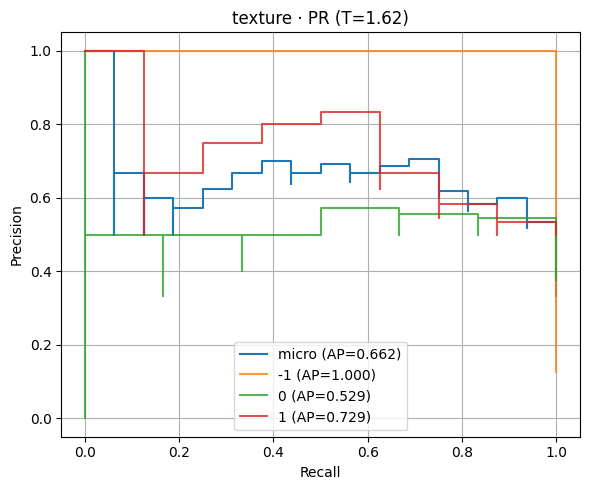

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 6, 0: 60, 1: 25} | y_va: {-1: 2, 0: 16, 1: 2} | y_te: {-1: 2, 0: 6, 1: 8}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.341  val_macroF1[TTA]=0.255
Warm 2/3 — tr_acc=0.549  val_macroF1[TTA]=0.647
Warm 3/3 — tr_acc=0.648  val_macroF1[TTA]=0.144

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.374  val_macroF1[TTA]=0.296
FT 2/15 — tr_acc=0.418  val_macroF1[TTA]=0.133
FT 3/15 — tr_acc=0.484  val_macroF1[TTA]=0.205
FT 4/15 — tr_acc=0.505  val_macroF1[TTA]=0.535
FT 5/15 — tr_acc=0.440  val_macroF1[TTA]=0.237
FT 6/15 — tr_acc=0.495  val_macroF1[TTA]=0.211
FT 7/15 — tr_acc=0.670  val_macroF1[TTA]=0.061
FT 8/15 — tr_acc=0.758  val_macroF1[TTA]=0.425
FT 9/15 — tr_acc=0.780  val_macroF1[TTA]=0.568
FT 10/15 — tr_acc=0.879  val_macroF1[TTA]=0.613
FT 11/15 — tr_acc=0.9

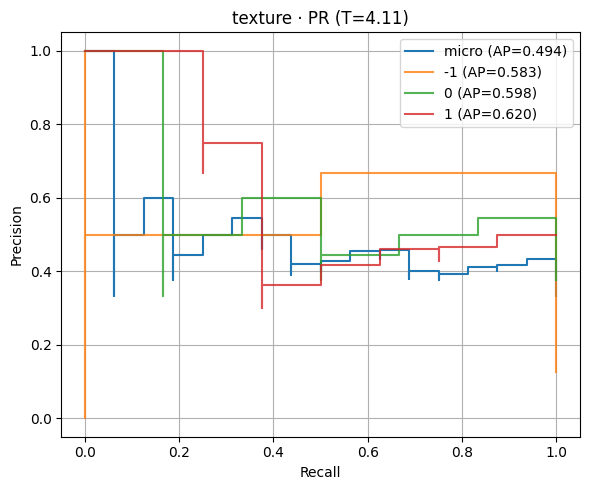

elasticity | backbone=dinov2_b14 | use_synthetic=True | 3 runs → mean=0.414 ± 0.260 (min=0.265, max=0.714)
→ Training feature: hyperpigmentation  | runs=3  | base_seed=2025
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 9, 0: 59, 1: 26} | y_va: {-1: 2, 0: 6, 1: 9} | y_te: {-1: 2, 0: 8, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.564  val_macroF1[TTA]=0.174
Warm 2/3 — tr_acc=0.426  val_macroF1[TTA]=0.291
Warm 3/3 — tr_acc=0.628  val_macroF1[TTA]=0.191

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.394  val_macroF1[TTA]=0.292
FT 2/15 — tr_acc=0.415  val_macroF1[TTA]=0.528
FT 3/15 — tr_acc=0.553  val_macroF1[TTA]=0.174
FT 4/15 — tr_acc=0.479  val_macroF1[TTA]=0.278
FT 5/15 — tr_acc=0.489  val_macroF1[TTA]=0.365
FT 6/15 — tr_acc=0.713  val_macroF1[TTA]=0.681
FT 7/15 — tr_acc=0.830  val_macroF1[TT

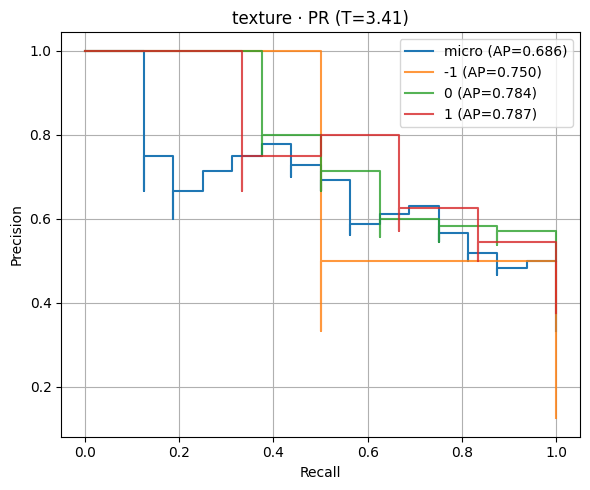

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 9, 0: 51, 1: 33} | y_va: {-1: 2, 0: 14, 1: 2} | y_te: {-1: 2, 0: 8, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.355  val_macroF1[TTA]=0.157
Warm 2/3 — tr_acc=0.505  val_macroF1[TTA]=0.093
Warm 3/3 — tr_acc=0.613  val_macroF1[TTA]=0.167

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.419  val_macroF1[TTA]=0.292
FT 2/15 — tr_acc=0.430  val_macroF1[TTA]=0.292
FT 3/15 — tr_acc=0.602  val_macroF1[TTA]=0.280
FT 4/15 — tr_acc=0.624  val_macroF1[TTA]=0.267
FT 5/15 — tr_acc=0.774  val_macroF1[TTA]=0.267
FT 6/15 — tr_acc=0.806  val_macroF1[TTA]=0.267
Early stopping on val macro-F1 (TTA).
Fitted temperature (val/TTA): T = 0.604

[hyperpigmentation] Test (TTA+TS) — macro-F1=0.222 | weighted-F1=0.333 | acc=0.500 | MCC=0.000 | QWK=0.000 | Top-2=0.938 | AUROC(mi

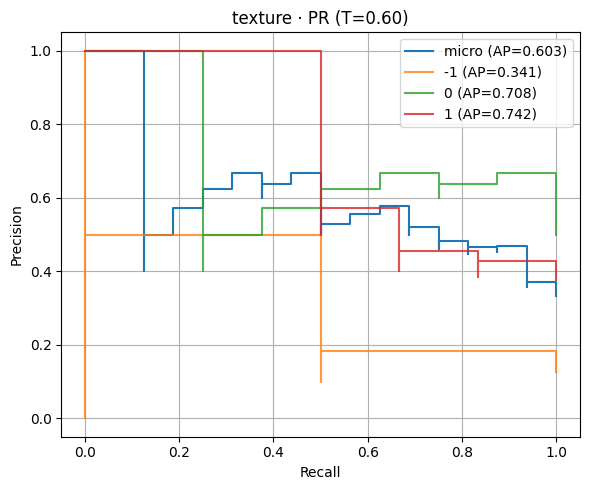

[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)
y_tr: {-1: 9, 0: 58, 1: 23} | y_va: {-1: 2, 0: 7, 1: 12} | y_te: {-1: 2, 0: 8, 1: 6}
[Backbone=dinov2_b14] input=(3, 518, 518)  mean=(0.485, 0.456, 0.406)  std=(0.229, 0.224, 0.225)

=== Warm-up (frozen encoder) ===
Warm 1/3 — tr_acc=0.433  val_macroF1[TTA]=0.400
Warm 2/3 — tr_acc=0.556  val_macroF1[TTA]=0.224
Warm 3/3 — tr_acc=0.500  val_macroF1[TTA]=0.395

=== Fine-tune (tiny LR, unfreeze last blocks) ===
FT 1/15 — tr_acc=0.478  val_macroF1[TTA]=0.167
FT 2/15 — tr_acc=0.433  val_macroF1[TTA]=0.167
FT 3/15 — tr_acc=0.467  val_macroF1[TTA]=0.242
FT 4/15 — tr_acc=0.467  val_macroF1[TTA]=0.329
FT 5/15 — tr_acc=0.556  val_macroF1[TTA]=0.445
FT 6/15 — tr_acc=0.622  val_macroF1[TTA]=0.410
FT 7/15 — tr_acc=0.656  val_macroF1[TTA]=0.495
FT 8/15 — tr_acc=0.678  val_macroF1[TTA]=0.735
FT 9/15 — tr_acc=0.789  val_macroF1[TTA]=0.698
FT 10/15 — tr_acc=0.856  val_macroF1[TTA]=0.767
FT 11/15 — tr_acc=0.8

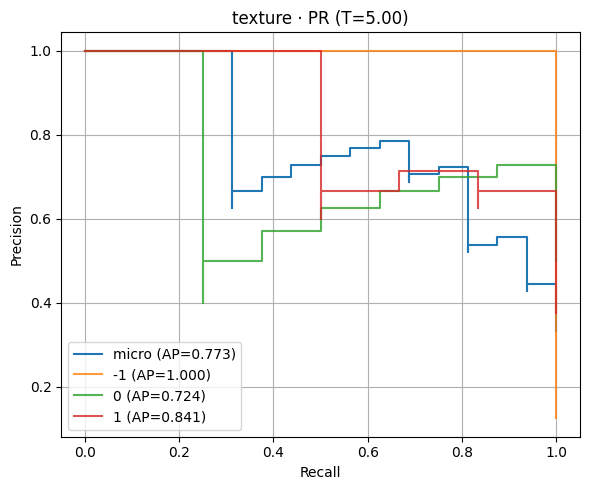

hyperpigmentation | backbone=dinov2_b14 | use_synthetic=True | 3 runs → mean=0.485 ± 0.243 (min=0.222, max=0.702)


In [65]:
if __name__ == "__main__":
    _init_results_csv()
    # single-feature
    #repeat_avg(feature="moisture", n_runs=3, base_seed=2025, use_synthetic=False)
    #repeat_avg(feature="moisture", n_runs=3, base_seed=2025, use_synthetic=True)

    # or all features:
    df_summary = run_all_features()

# PANDERM (Large)

In [17]:
# 3 RUNS WITH AVERAGE
import random, numpy as np, torch

def repeat_avg(feature, n_runs=3, base_seed=2025, use_synthetic=False):
    f1s = []
    rows = []
    for i in range(n_runs):
        s = base_seed + i
        random.seed(s); np.random.seed(s)
        torch.manual_seed(s); torch.cuda.manual_seed_all(s)
        _, f1, row = train_one_feature(feature=feature, use_synthetic=use_synthetic, seed=s)
        f1s.append(float(f1)); rows.append(row)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    f1s = np.array(f1s, float)
    print(f"{feature} | {n_runs} runs → mean={f1s.mean():.3f} ± {f1s.std():.3f} "
          f"(min={f1s.min():.3f}, max={f1s.max():.3f})")
    #print(f"  - run {i+1}/{n_runs} (seed={s})", flush=True)
    return f1s, rows

## ALL FEATURES

In [35]:
import warnings
warnings.filterwarnings("ignore")


In [51]:
def run_all_features(features=None, n_runs=3, base_seed=2025):
    _init_results_csv()
    if features is None:
        features = list(FEATURE_LABELS.keys())
    summary = []
    for use_syn in (False, True):
        print(f"\n==== use_synthetic={use_syn} ====")
        for feat in features:
            print(f"→ Training feature: {feat}  | runs={n_runs}  | base_seed={base_seed}", flush=True)
            f1s, rows = repeat_avg(feature=feat, n_runs=n_runs, base_seed=base_seed, use_synthetic=use_syn)
            summary.append({
                "feature": feat,
                "use_synthetic": use_syn,
                "mean_macro_f1": float(f1s.mean()),
                "std_macro_f1": float(f1s.std())
            })
    return pd.DataFrame(summary)


In [ ]:
if __name__ == "__main__":
    _init_results_csv()
    # single-feature
    #repeat_avg(feature="moisture", n_runs=3, base_seed=2025, use_synthetic=False)
    #repeat_avg(feature="moisture", n_runs=3, base_seed=2025, use_synthetic=True)

    # or all features:
    df_summary = run_all_features()

# DUMMY BASELINE COMPUTATION

In [2]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, confusion_matrix

# -----------------------------
# Your config (as given)
# -----------------------------
CSV_TRAIN_POOL = "/content/drive/MyDrive/Skin_project/train_original.csv"

CSV_TEST_FIXED = "/content/drive/MyDrive/Skin_project/test_original.csv"

FEATURE = "moisture"  # change as needed

feature2imgcol = {
    "moisture": "moisture_img",
    "oiliness": "oiliness_img",
    "elasticity": "elasticity_img",
    "texture": "texture_img",
    "hyperpigmentation": "hyperpigmentation_img",
}
DEFAULT_LABELS = [-1, 0, 1]
BINARY_MAP = {
    "oiliness": { -1: 0, 0: 1, 1: 1 },  # dry vs non-dry
    "moisture": { -1: 0, 0: 1, 1: 1 },
}
FEATURE_LABELS = {
    "oiliness":  [0, 1],
    "moisture":  [0, 1],
    "texture":   [-1, 0, 1],
    "elasticity":[-1, 0, 1],
    "hyperpigmentation":[-1, 0, 1],
}

# -----------------------------
# Helper: load labels with the same mapping you use in experiments
# -----------------------------
def load_labels(csv_path, feature):
    lbl_col = f"{feature}_score"
    y = (pd.read_csv(csv_path)[lbl_col]
         .dropna()
         .astype(float).round().astype(int)
         .values)
    # Apply binary mapping only when defined
    if feature in BINARY_MAP:
        y = np.array([BINARY_MAP[feature].get(int(v), v) for v in y], dtype=int)
    # Keep only allowed labels for this feature
    allowed = set(FEATURE_LABELS.get(feature, DEFAULT_LABELS))
    y = np.array([int(v) for v in y if int(v) in allowed], dtype=int)
    return y

# -----------------------------
# Dummy baselines
# -----------------------------
def run_dummy_baselines(feature):
    y_tr = load_labels(CSV_TRAIN_POOL, feature)
    y_te = load_labels(CSV_TEST_FIXED, feature)

    # Trivial features so DummyClassifier fits
    X_tr = np.zeros((len(y_tr), 1))
    X_te = np.zeros((len(y_te), 1))

    results = {}
    for strat in ["most_frequent", "uniform", "stratified"]:
        d = DummyClassifier(strategy=strat, random_state=42).fit(X_tr, y_tr)
        yp = d.predict(X_te)
        macro_f1 = f1_score(y_te, yp, average="macro", zero_division=0)
        cm = confusion_matrix(y_te, yp, labels=np.unique(y_te)).astype(float)
        bal_acc = (cm / cm.sum(1, keepdims=True)).diagonal().mean()
        results[strat] = dict(macro_f1=float(macro_f1), balanced_acc=float(bal_acc))

    return results

# -----------------------------
# Run
# -----------------------------
res = run_dummy_baselines(FEATURE)
for k, v in res.items():
    print(f"{FEATURE:>18} | {k:13s} -> macro-F1={v['macro_f1']:.3f} | bal-acc={v['balanced_acc']:.3f}")


          moisture | most_frequent -> macro-F1=0.385 | bal-acc=0.500
          moisture | uniform       -> macro-F1=0.418 | bal-acc=0.433
          moisture | stratified    -> macro-F1=0.467 | bal-acc=0.467


In [3]:

FEATURE = "oiliness"
res = run_dummy_baselines(FEATURE)
for k, v in res.items():
    print(f"{FEATURE:>18} | {k:13s} -> macro-F1={v['macro_f1']:.3f} | bal-acc={v['balanced_acc']:.3f}")

          oiliness | most_frequent -> macro-F1=0.467 | bal-acc=0.500
          oiliness | uniform       -> macro-F1=0.385 | bal-acc=0.357
          oiliness | stratified    -> macro-F1=0.816 | bal-acc=0.750


In [4]:
FEATURE = "elasticity"
res = run_dummy_baselines(FEATURE)
for k, v in res.items():
    print(f"{FEATURE:>18} | {k:13s} -> macro-F1={v['macro_f1']:.3f} | bal-acc={v['balanced_acc']:.3f}")

        elasticity | most_frequent -> macro-F1=0.182 | bal-acc=0.333
        elasticity | uniform       -> macro-F1=0.240 | bal-acc=0.222
        elasticity | stratified    -> macro-F1=0.259 | bal-acc=0.306


In [5]:
FEATURE = "texture"
res = run_dummy_baselines(FEATURE)
for k, v in res.items():
    print(f"{FEATURE:>18} | {k:13s} -> macro-F1={v['macro_f1']:.3f} | bal-acc={v['balanced_acc']:.3f}")

           texture | most_frequent -> macro-F1=0.256 | bal-acc=0.333
           texture | uniform       -> macro-F1=0.411 | bal-acc=0.567
           texture | stratified    -> macro-F1=0.326 | bal-acc=0.350


In [6]:
FEATURE = "hyperpigmentation"
res = run_dummy_baselines(FEATURE)
for k, v in res.items():
    print(f"{FEATURE:>18} | {k:13s} -> macro-F1={v['macro_f1']:.3f} | bal-acc={v['balanced_acc']:.3f}")

 hyperpigmentation | most_frequent -> macro-F1=0.222 | bal-acc=0.333
 hyperpigmentation | uniform       -> macro-F1=0.244 | bal-acc=0.264
 hyperpigmentation | stratified    -> macro-F1=0.297 | bal-acc=0.319
